In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb
from shapely.geometry import shape
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
from datetime import datetime

from sentinelsat import SentinelAPI
import pandas as pd
from datetime import datetime
from datetime import date
import glob
from collections import OrderedDict
import os
import csv
import random

import numpy as np

import requests
import json
import getpass

from tqdm import tqdm
from google.cloud import storage

from utils.prep_utils import s3_list_objects_paths, s3_list_objects, s3_download, s3_upload_cogs, create_yaml, get_geometry
from utils.prepS1 import get_s1_asf_urls


In [4]:
ls /tmp/data

ancillary/  outputs/


In [5]:
def get_s2_csvfile(gc_path, loc_path):

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name="gcp-public-data-sentinel-2", user_project=None)

    blobs = bucket.list_blobs(prefix=gc_path)  # Get list of files
    blob = [i for i in blobs][0]
    
    blob.download_to_filename(loc_path)

- speed up world tiles querying by inverting search
- speed up gcloud zipped csvs by parallelising(?)
- convert into functions/tools rather than nb


# **INPUTS**

In [6]:
# req
region = 'United Kingdom' # any country name OR wkt in epsg 3426
# region = 'POLYGON((177.44 -17.52,177.65 -17.52,177.65 -17.73,177.44 -17.73,177.44 -17.52))'
fiji_am = False

update_acqs_s2_gcloud = False
update_acqs_ls_usgs = False

# **VARS**

In [7]:
# deafult
inter_dir = '/tmp/data/' # local directory for any processing and outputs
# products = {
#     'SENTINEL_1':{
#         'PRODUCTS':['GRD'],
#         'SOURCES':['ESAHUB','ASF']
#     },
#     'SENTINEL_2':{
#         'PRODUCTS':['L2A'],
#         'SOURCES':['ESAHUB','GCLOUD']
#     },
#     'LANDSAT_8':{
#         'PRODUCTS'['L1'],
#         'SOURCES':['USGS']
#     },
#     'LANDSAT_7':{
#         'PRODUCTS'['L1'],
#         'SOURCES':['USGS']
#     },
#     'LANDSAT_5':{
#         'PRODUCTS'['L1'],
#         'SOURCES':['USGS']
#     },
#     'LANDSAT_4':{
#         'PRODUCTS'['L1'],
#         'SOURCES':['USGS']
#     }
# }
# outputs = ['csvs','shp','granule_maps','temporal_plots']

# optional
upload = False # if False then below can be ignored
s3_bucket = 'public-eo-data'
jobs_s3dir = 'common_sensing/tom/dataprep_jobs/'

In [8]:
if fiji_am:
    plot_crs = {"init": "epsg:3460"}
else:
    plot_crs = {"init": "epsg:4326"}

In [9]:
os.makedirs(f'{inter_dir}ancillary', exist_ok=True)
os.makedirs(f'{inter_dir}outputs', exist_ok=True)

# **Check Req Envs**

In [10]:
source_envars = {
    'ESAHUB':['COPERNICUS_USERNAME','COPERNICUS_PWD'],
    'ASF':['ASF_USERNAME','ASF_PWD'],
    'USGS':['USGS_USERNAME','USGS_PWD']
}

In [11]:
for envars in source_envars:
    for var in source_envars[envars]:
        print(var,':',os.getenv(var)!=None)

COPERNICUS_USERNAME : True
COPERNICUS_PWD : True
ASF_USERNAME : True
ASF_PWD : True
USGS_USERNAME : True
USGS_PWD : True


# **Download any necessary AoI Vectors and Ancillary datasets**

In [12]:
# local paths
anc_dir = f'{inter_dir}ancillary/'
anc_dir_rem = 'common_sensing/ancillary_products/'
anc_paths = {
    's2tiles_path': [f'{anc_dir}sentinel2_tiles_world.geojson',f'{anc_dir_rem}SatelliteSceneTiles/sentinel2_tiles_world/sentinel2_tiles_world.geojson'],
    'lstiles_path': [f'{anc_dir}WRS2_descending.geojson',f'{anc_dir_rem}SatelliteSceneTiles/landsat_pr/WRS2_descending.geojson'],
    'wborders_path': [f'{anc_dir}TM_WORLD_BORDERS.geojson',f'{anc_dir_rem}TM_WORLD_BORDERS/TM_WORLD_BORDERS.geojson'],
    's2l1csv_path': [f'{anc_dir}L1_index.csv.gz','index.csv.gz'],
    's2l2csv_path': [f'{anc_dir}L2_index.csv.gz','L2/index.csv.gz'],
    'ls8csv_path': [f'{anc_dir}LANDSAT_8_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_8_C1.csv.gz'],
    'ls7csv_path': [f'{anc_dir}LANDSAT_7_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_ETM_C1.csv.gz'],
    'ls45csv_path': [f'{anc_dir}LANDSAT_45_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_TM_C1.csv.gz'],
    'ls12csv_path': [f'{anc_dir}LANDSAT_12_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_MSS_C1.csv.gz']
}

In [13]:
loc_anc_exists = dict(zip(anc_paths.keys(), [os.path.exists(anc_paths[i][0]) for i in anc_paths]))
print(loc_anc_exists)

{'s2tiles_path': True, 'lstiles_path': True, 'wborders_path': True, 's2l1csv_path': True, 's2l2csv_path': True, 'ls8csv_path': True, 'ls7csv_path': True, 'ls45csv_path': True, 'ls12csv_path': True}


In [14]:
%%time
# get fixed anc files
fixed_ancs = ['s2tiles_path','lstiles_path','wborders_path']
for f in tqdm(fixed_ancs):
    if os.path.exists(anc_paths[f][0]) == False:
        print(f'Downloading {anc_paths[f][1]}')
        s3_download(s3_bucket, anc_paths[f][1], anc_paths[f][0])
        print(f'Downloaded {anc_paths[f][1]}')        
    else:
        print(f'{anc_paths[f][0]} already available')
        
# get variable anc files if unavailable or need to be updated
var_ancs_gc = ['s2l1csv_path','s2l2csv_path']
for f in tqdm(var_ancs_gc):    
    if (os.path.exists(anc_paths[f][0]) == False) | (update_acqs_s2_gcloud == True):
        print(f'Downloading {anc_paths[f][1]}')
        get_s2_csvfile(anc_paths[f][1], anc_paths[f][0])
        print(f'Downloaded {anc_paths[f][1]}')
    else:
        print(f'{anc_paths[f][0]} already available')
var_ancs_urls = ['ls8csv_path','ls7csv_path','ls45csv_path','ls12csv_path']
for f in tqdm(var_ancs_urls):
    if (os.path.exists(anc_paths[f][0]) == False) | (update_acqs_ls_usgs == True):
        print(f'Downloading {anc_paths[f][1]}')
        open(f'{anc_paths[f][0]}', 'wb').write(requests.get(anc_paths[f][1]).content)
        print(f'Downloaded {anc_paths[f][1]}')
    else:
        print(f'{anc_paths[f][0]} already available')

100%|██████████| 4/4 [00:00<00:00, 4340.81it/s]

/tmp/data/ancillary/sentinel2_tiles_world.geojson already available
/tmp/data/ancillary/WRS2_descending.geojson already available
/tmp/data/ancillary/TM_WORLD_BORDERS.geojson already available
/tmp/data/ancillary/L1_index.csv.gz already available
/tmp/data/ancillary/L2_index.csv.gz already available
/tmp/data/ancillary/LANDSAT_8_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_7_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_45_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_12_C1_new.csv.gz already available
CPU times: user 18.3 ms, sys: 4.15 ms, total: 22.4 ms
Wall time: 17.6 ms


# **CREATE AOI**

POLYGON ((-8.621389000000001 49.9116590000001, 1.749444 49.9116590000001, 1.749444 60.844444, -8.621389000000001 60.844444, -8.621389000000001 49.9116590000001))


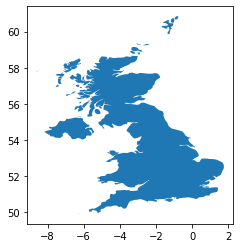

In [15]:
world_borders = gpd.read_file(anc_paths['wborders_path'][0])
if region in world_borders.NAME.values:
    aoi = world_borders.loc[world_borders.NAME == region]
    region_name = region
else:
    aoi = pd.DataFrame(data={'geometry': [region]})
    aoi['geometry'] = aoi['geometry'].apply(wkt.loads)
    aoi = gpd.GeoDataFrame(aoi, geometry='geometry', crs=('epsg:4326'))
    aoi['NAME'] = 'RegionName'
    region_name = 'RegionName'
aoi_wkt = aoi.to_crs(plot_crs).envelope.to_crs({"init": "epsg:4326"}).values[0].wkt
print(aoi_wkt)
aoi.to_crs(plot_crs).plot();

# **SENTINEL_2**

### DETERMINE OVERLAPPING GRANULES

In [19]:
# load world granules
world_granules = gpd.read_file(anc_paths['s2tiles_path'][0])
# Create bool for intersection between any tiles - should try inversion to speed up...
for n, g in zip(aoi.NAME, aoi.geometry):
    world_granules[n] = world_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
world_granules[region_name] = world_granules[world_granules[aoi.NAME.values]].any(1)
region_s2_grans = world_granules[world_granules[region_name]==True]

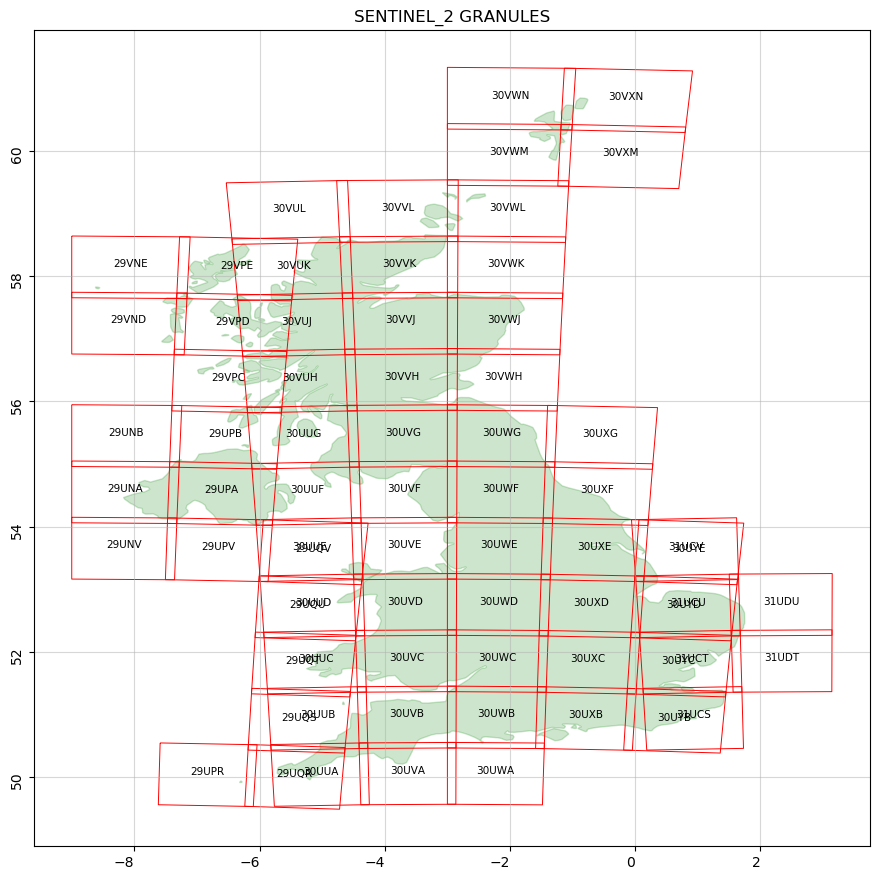

In [20]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

x = region_s2_grans.to_crs(plot_crs).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
region_s2_grans.to_crs(plot_crs).apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

ax.set_title('SENTINEL_2 GRANULES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

### ESA QUERY

In [23]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [24]:
# l2a results
res = esa_api.query(aoi_wkt, platformname='Sentinel-2',producttype='S2MSI2A')
esa_l2a = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 49336/49336 [13:22<00:00, 61.50 products/s]


In [25]:
# l1c results
res = esa_api.query(aoi_wkt, platformname='Sentinel-2', producttype='S2MSI1C')
esa_l1c = esa_api.to_geodataframe(res)
l1c = esa_l1c

Querying products: 100%|██████████| 83129/83129 [22:45<00:00, 60.87 products/s]


In [26]:
# Add shortened scene name
esa_l1c['scenename'] = esa_l1c.title.apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}_{x.split('_')[2]}_{x.split('_')[5]}")
esa_l2a['scenename'] = esa_l2a.title.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")
esa_l1c['granules'] = esa_l1c.identifier.str[39:44]
esa_l2a['granules'] = esa_l2a.identifier.str[39:44]

In [27]:
# CHECK EARLIEST ACQUISITIONS ALIGN WITH KNOWN AVAILABILITY
esa_l1c = esa_l1c.sort_values('beginposition', ascending=True)
esa_l2a = esa_l2a.sort_values('beginposition', ascending=True)
print(f'Tot. No. L1C Prods: {len(esa_l1c)} | Tot. No. L2A Prods: {len(esa_l2a)}')
print('First 2, last 2 products...')
print(list(esa_l1c.title.values[:2]))
print(list(esa_l2a.title.values[:2]))
print(list(esa_l1c.title.values[-2:]))
print(list(esa_l2a.title.values[-2:]))
print('Sorted...')
esa_l1c_srt = esa_l1c.sort_values('beginposition', ascending=False)
esa_l2a_srt = esa_l2a.sort_values('beginposition', ascending=False)
print(list(esa_l1c_srt.title.values[-2:]))
print(list(esa_l2a_srt.title.values[-2:]))

Tot. No. L1C Prods: 83129 | Tot. No. L2A Prods: 49336
First 2, last 2 products...
['S2A_MSIL1C_20150706T105016_N0204_R051_T31UCR_20150706T105351', 'S2A_MSIL1C_20150706T105016_N0204_R051_T31UDS_20150706T105351']
['S2B_MSIL2A_20180326T112109_N0207_R037_T29UQU_20180326T131657', 'S2B_MSIL2A_20180326T112109_N0207_R037_T30VWM_20180326T122926']
['S2A_MSIL1C_20200607T115411_N0209_R023_T29VPC_20200607T134737', 'S2A_MSIL1C_20200607T115411_N0209_R023_T30VVN_20200607T134737']
['S2A_MSIL2A_20200607T115411_N0214_R023_T29UPB_20200607T142238', 'S2A_MSIL2A_20200607T115411_N0214_R023_T29VPH_20200607T142238']
Sorted...
['S2A_MSIL1C_20150706T105016_N0204_R051_T31UDS_20150706T105351', 'S2A_MSIL1C_20150706T105016_N0204_R051_T31UCR_20150706T105351']
['S2B_MSIL2A_20180326T112109_N0207_R037_T31VDF_20180326T122926', 'S2B_MSIL2A_20180326T112109_N0207_R037_T29UQU_20180326T131657']


In [28]:
# Filter L1C scenes that have already been processed to L2A
print(f'Tot No. L1C Scenes (AoI Envelope): {esa_l1c_srt.shape}')
esa_l1c_srt = esa_l1c_srt.loc[~esa_l1c_srt['scenename'].isin(esa_l2a_srt.scenename.values)]
print(f'No. nonL2A L1C Scenes (AoI Envelope): {esa_l1c_srt.shape}')
print(f'No. L2A Scenes (AoI Envelope): {esa_l2a_srt.shape}')

Tot No. L1C Scenes (AoI Envelope): (83129, 36)
No. nonL2A L1C Scenes (AoI Envelope): (33784, 36)
No. L2A Scenes (AoI Envelope): (49336, 37)


In [29]:
# Filter search results to specific tiles needed (i.e. from tiles shapefile)
esa_l1c_precise = esa_l1c_srt[esa_l1c_srt['granules'].isin(region_s2_grans.Name.values)]
esa_l2a_precise = esa_l2a_srt[esa_l2a_srt['granules'].isin(region_s2_grans.Name.values)]
print(f'No. nonL2A L1C Scenes (Precise Tiles): {esa_l1c_precise.shape}')
print(f'No. L2A Scenes (Precise Tiles): {esa_l2a_precise.shape}')

No. nonL2A L1C Scenes (Precise Tiles): (21150, 36)
No. L2A Scenes (Precise Tiles): (30520, 37)


### GCLOUD QUERY

In [30]:
# Get tile names from ESA S2 tiles shapefile (from above)
s2_tiles = list(region_s2_grans.Name.values)
len(s2_tiles)

70

In [31]:
# Read all GCloud L1C acquisitions and filter to those of desired tiles - takes too long
gc = pd.read_csv(anc_paths['s2l1csv_path'][0])
gc_l1c = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None
# Read all GCloud L2A acquisitions and filter to those of desired tiles - takes too long
gc = pd.read_csv(anc_paths['s2l2csv_path'][0])
gc_l2a = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None

In [32]:
# Create shortened name as with esa
print(f'Tot No. L2A GCloud Scenes (Precise Tiles): {gc_l2a.shape}')
print(f'Tot No. L1C GCloud Scenes (Precise Tiles): {gc_l1c.shape}')
gc_l2a['scenename'] = gc_l2a.PRODUCT_ID.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")
gc_l1c['scenename'] = gc_l1c.PRODUCT_ID.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")

Tot No. L2A GCloud Scenes (Precise Tiles): (38724, 14)
Tot No. L1C GCloud Scenes (Precise Tiles): (56149, 14)


In [33]:
# Filter to only scenes that match esa
gc_l2a_match = gc_l2a.loc[gc_l2a['scenename'].isin(esa_l2a_precise.scenename.values)]
gc_l1c_match = gc_l1c.loc[gc_l1c['scenename'].isin(esa_l1c_precise.scenename.values)]
print(f'Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): {gc_l2a_match.shape}')
print(f'Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): {gc_l1c_match.shape}')

Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): (30233, 15)
Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): (19966, 15)


In [34]:
# Filter L1C scenes that have already been processed to L2A
print(f'Tot No. L1C Scenes (Precise AoI): {gc_l1c_match.shape}')
gc_l1c_match = gc_l1c_match.loc[~gc_l1c_match['scenename'].isin(gc_l2a_match.scenename.values)]
print(f'No. nonL2A L1C Scenes (Precise AoI): {gc_l1c_match.shape}')
print(f'No. L2A Scenes (Precise AoI): {gc_l2a_match.shape}')

Tot No. L1C Scenes (Precise AoI): (19966, 15)
No. nonL2A L1C Scenes (Precise AoI): (19966, 15)
No. L2A Scenes (Precise AoI): (30233, 15)


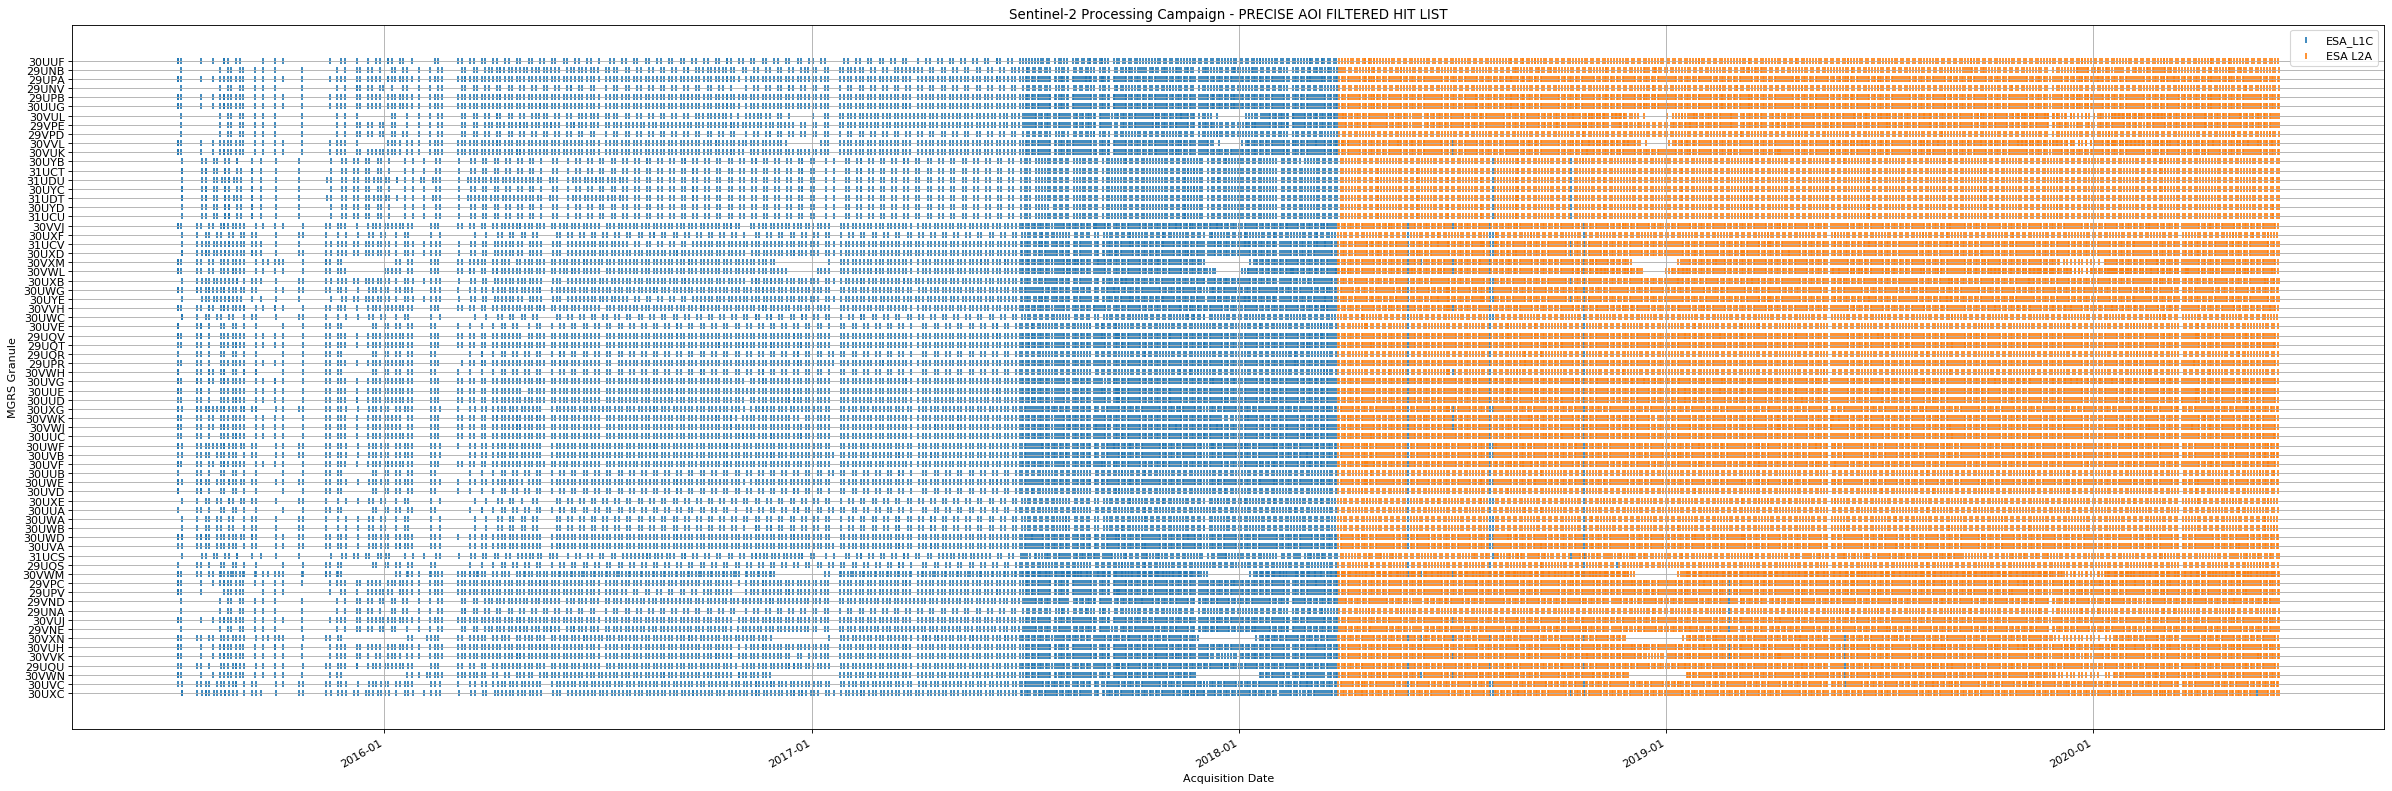

In [35]:
# Plot temporality of L1C and L2A
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = esa_l1c_precise
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

df = esa_l2a_precise
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

# df = gc_l1c_match
# df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
# df['granules'] = df['MGRS_TILE']
# # remove files showing as NaN size
# df = df.dropna(subset=['TOTAL_SIZE'])
# #df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
# ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='_');

# df = gc_l2a_match
# df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
# df['granules'] = df['MGRS_TILE']
# # remove files showing as NaN size
# df = df.dropna(subset=['TOTAL_SIZE'])
# #df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
# ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

ax.set_ylabel('MGRS Granule');
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_L1C','ESA L2A','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title("Sentinel-2 Processing Campaign - PRECISE AOI FILTERED HIT LIST");
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

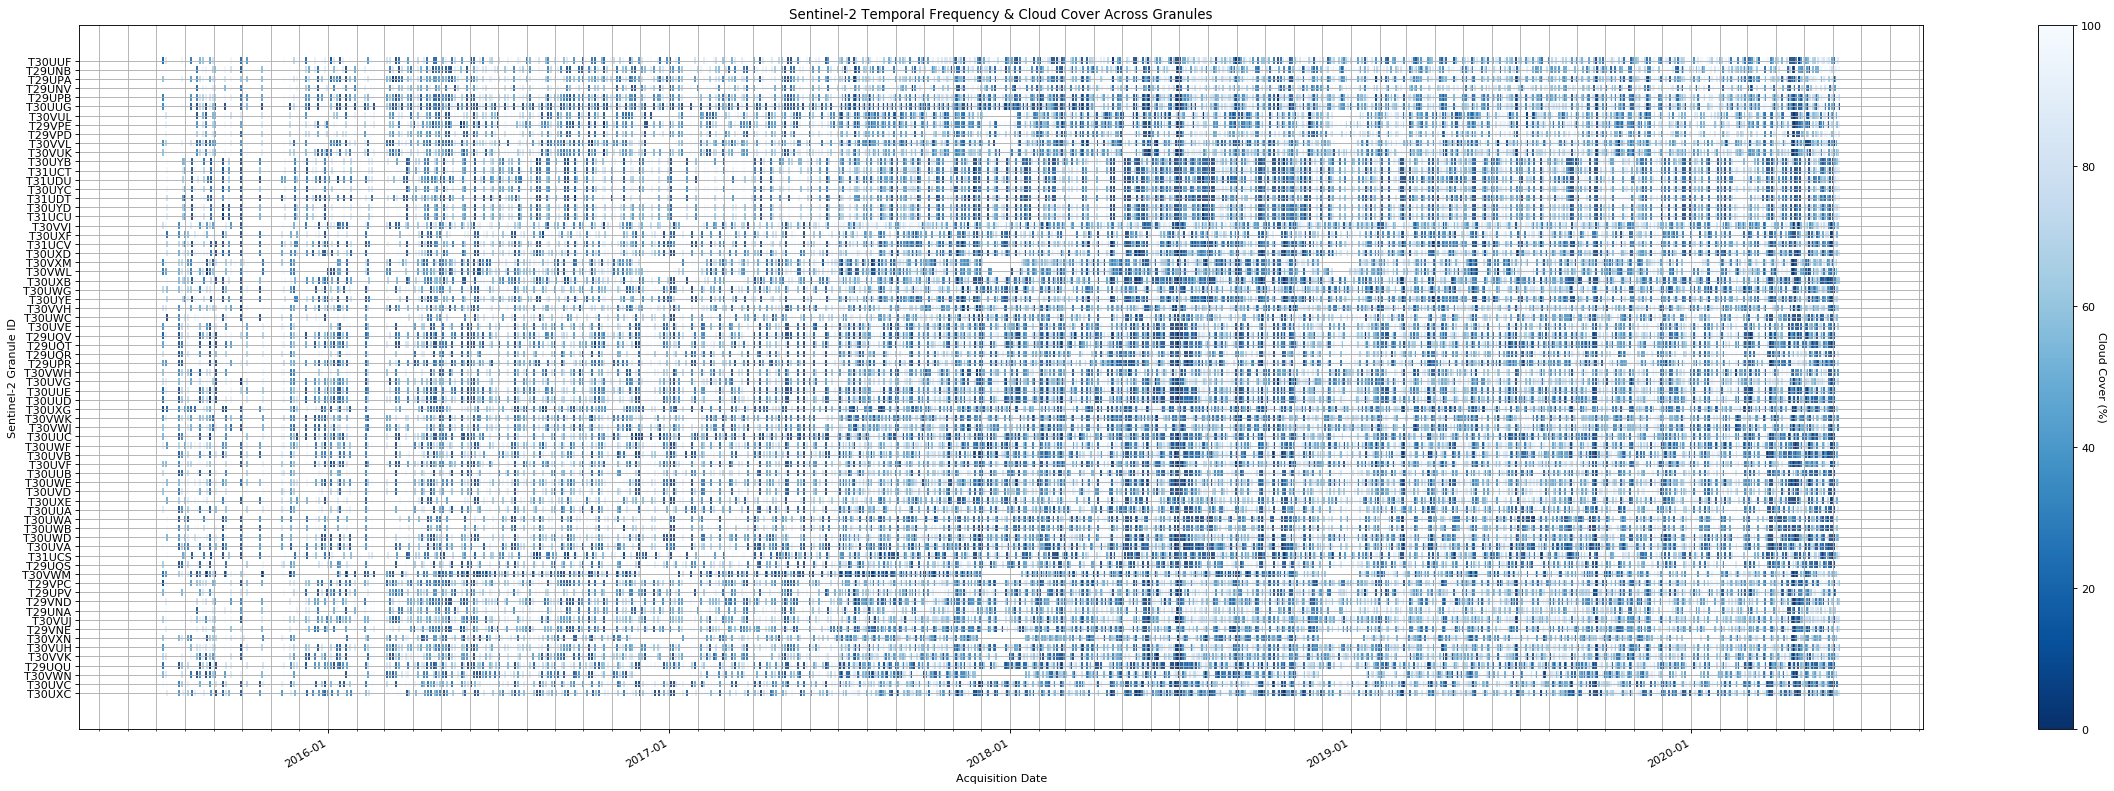

In [60]:
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

# df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df = esa_l1c_precise
df['s1platform'] = df['identifier'].str[:3]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granules'] = df.identifier.str[38:44]

img1 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudcoverpercentage'].values, cmap='Blues_r');

df = esa_l2a_precise
df['s1platform'] = df['identifier'].str[:3]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granules'] = df.identifier.str[38:44]

img1 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudcoverpercentage'].values, cmap='Blues_r');


cbar = fig.colorbar(img1, ax=ax)
cbar.set_label('Cloud Cover (%)', rotation=270)
ax.set_ylabel("Sentinel-2 Granule ID");
ax.set_xlabel("Acquisition Date");
ax.set_title('Sentinel-2 Temporal Frequency & Cloud Cover Across Granules');
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.xaxis.set_minor_locator(mdates.MonthLocator());
#ax.xaxis.set_minor_formatter(DateFormatter(""%Y-%m"") ); 
ax.grid(which='both')
fig.tight_layout()

#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_polarisation');

### CROSS-CHECK AGAINST S3 BUCKET

In [88]:
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/fiji/sentinel_2'

In [89]:
s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [90]:
s3_nms = [i.split('/')[-2] for i in yamls]
esa_l2_nms = [i.replace('MSIL1C','MSIL2A') for i in esa_l2a_precise.scenename.values]
esa_l2a_precise['SAC_DONE'] = [ i in s3_nms for i in esa_l2_nms]
esa_l1_nms = [i.replace('MSIL1C','MSIL2A') for i in esa_l1c_precise.scenename.values]
esa_l1c_precise['SAC_DONE'] = [ i in s3_nms for i in esa_l1_nms]

esa_l2a_precise['SAC_DONE'].value_counts(), esa_l1c_precise['SAC_DONE'].value_counts()

(True     3807
 False     105
 Name: SAC_DONE, dtype: int64,
 False    5296
 Name: SAC_DONE, dtype: int64)

### CROSS-CHECK ESA AGAINST GCLOUD

In [36]:
esa_l1c_precise['GCLOUD_PRES'] = [i in gc_l1c_match.scenename.values  for i in esa_l1c_precise.scenename.values]
esa_l2a_precise['GCLOUD_PRES'] = [i in gc_l2a_match.scenename.values  for i in esa_l2a_precise.scenename.values]

esa_l2a_precise['GCLOUD_PRES'].value_counts(), esa_l1c_precise['GCLOUD_PRES'].value_counts()

(True     30062
 False      458
 Name: GCLOUD_PRES, dtype: int64,
 True     19958
 False     1192
 Name: GCLOUD_PRES, dtype: int64)

In [92]:
# esa_l1c_precise['ESA_ONLINE'] = [ esa_api.get_product_odata(i)['Online'] for i in tqdm(esa_l1c_precise.uuid.values) ]
# esa_l2a_precise['ESA_ONLINE'] = [ esa_api.get_product_odata(i)['Online'] for i in tqdm(esa_l2a_precise.uuid.values) ]
# esa_l2a_precise['ESA_ONLINE'].value_counts(), esa_l1c_precise['ESA_ONLINE'].value_counts()

### SAVE DFS

In [40]:
td = datetime.today()
td = td.strftime('%Y')+td.strftime('%m')+td.strftime('%d')
cols = ['title','scenename','cloudcoverpercentage','platformname','Acquisition Date','granules','GCLOUD_PRES','uuid','geometry']

In [41]:
(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L2A.csv",
f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L1C.csv",
 f"{inter_dir}outputs/SD_{td}_{region_name}_S1_GRD.csv",
f"{inter_dir}outputs/SD_{td}_{region_name}_LS_C1.csv",
f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L2A.txt")

('/tmp/data/outputs/SD_20200608_United Kingdom_S2_L2A.csv',
 '/tmp/data/outputs/SD_20200608_United Kingdom_S2_L1C.csv',
 '/tmp/data/outputs/SD_20200608_United Kingdom_S1_GRD.csv',
 '/tmp/data/outputs/SD_20200608_United Kingdom_LS_C1.csv',
 '/tmp/data/outputs/JOBLIST_20200608_United Kingdom_S2_L2A.txt')

In [42]:
# save to L1 & L2 csvs
esa_l2a_precise[cols].to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L2A.csv")
esa_l1c_precise[cols].to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L1C.csv")

### CREATE JOBLIST

In [44]:
# to_do_l1 = []
# for s, p in zip(esa_l1c_precise.title.values, esa_l1c_precise.SAC_DONE):
#     if not p:
#         to_do_l1.append(s)
# print(len(to_do_l1),to_do_l1[0])
# to_do_l2 = []
# for s, p in zip(esa_l2a_precise.title.values, esa_l2a_precise.SAC_DONE):
#     if not p:
#         to_do_l2.append(s)
# print(len(to_do_l2),to_do_l2[0])

In [45]:
with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L1C.txt", 'a') as t:
    for v in esa_l1c_precise.title.values:
        t.write("rpush jobS2"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/UK/sentinel_2/"'+"}'" + '\n')

with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L2A.txt", 'a') as t:
    for v in esa_l2a_precise.title.values:
        t.write("rpush jobS2"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/UK/sentinel_2/"'+"}'" + '\n')

# **SENTINEL-1**

## ESA QUERY

In [522]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [523]:
# ESA Query
res = esa_api.query(aoi_wkt,platformname='Sentinel-1',producttype='GRD',sensoroperationalmode='IW')
esa_grd = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 29591/29591 [10:43<00:00, 46.00 products/s]


## ASF QUERY

In [524]:
asf_grd_matches = get_s1_asf_urls(esa_grd.title.values) # add tqdm to underlying query

100%|██████████| 249/249 [07:16<00:00,  1.75s/it]


In [525]:
df = pd.merge(left=esa_grd, right=asf_grd_matches, how='left', left_on='title', right_on='Granule Name')

In [526]:
# df = esa_grd

In [527]:
# Create bool for intersection between any tiles 
for n, g in zip(aoi.NAME, aoi.geometry):
    df[n] = df.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
df[region_name] = df[df[aoi.NAME.values]].any(1)
df_c = df[df[region_name]==True]

In [528]:
df_c.shape

(19513, 67)

In [530]:
df_c.to_csv("/tmp/data/outputs/SD_20200612_United Kingdom_S1_GRD.csv")

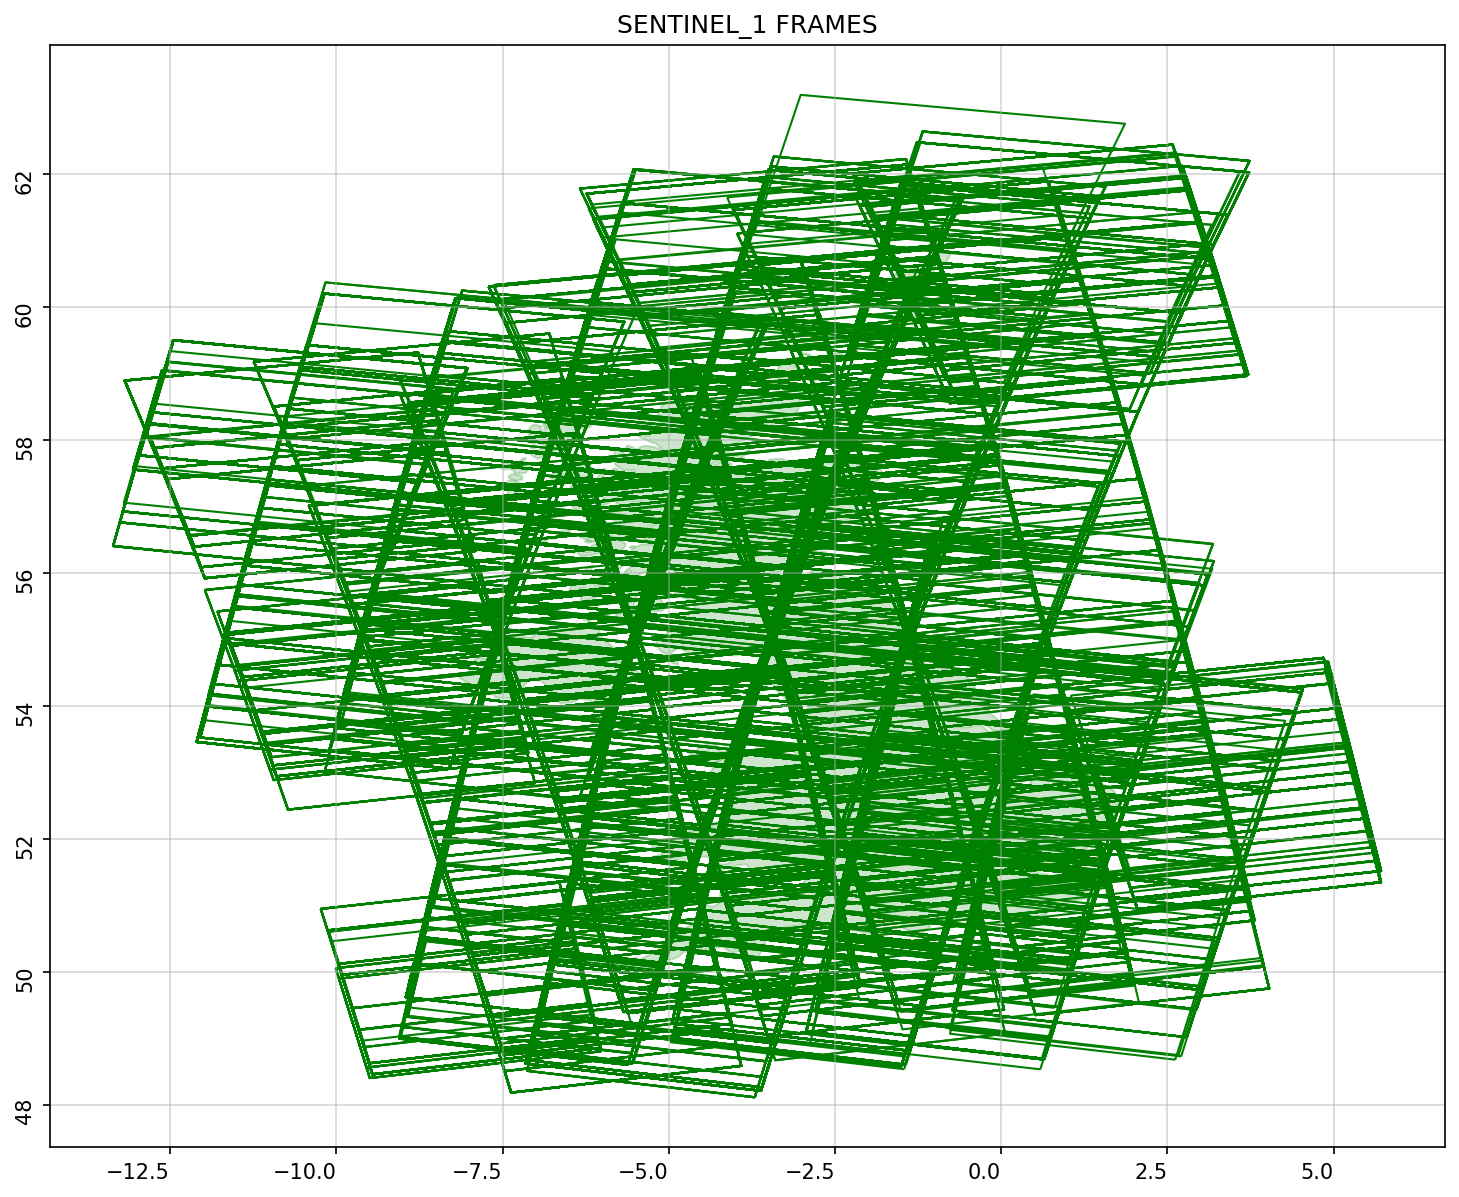

In [529]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

df_c.to_crs(plot_crs).plot(facecolor='',edgecolor='g',ax=ax)

ax.set_title('SENTINEL_1 FRAMES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

## ADDRESS ANTI_MERIDIAN NON-OVERLAP

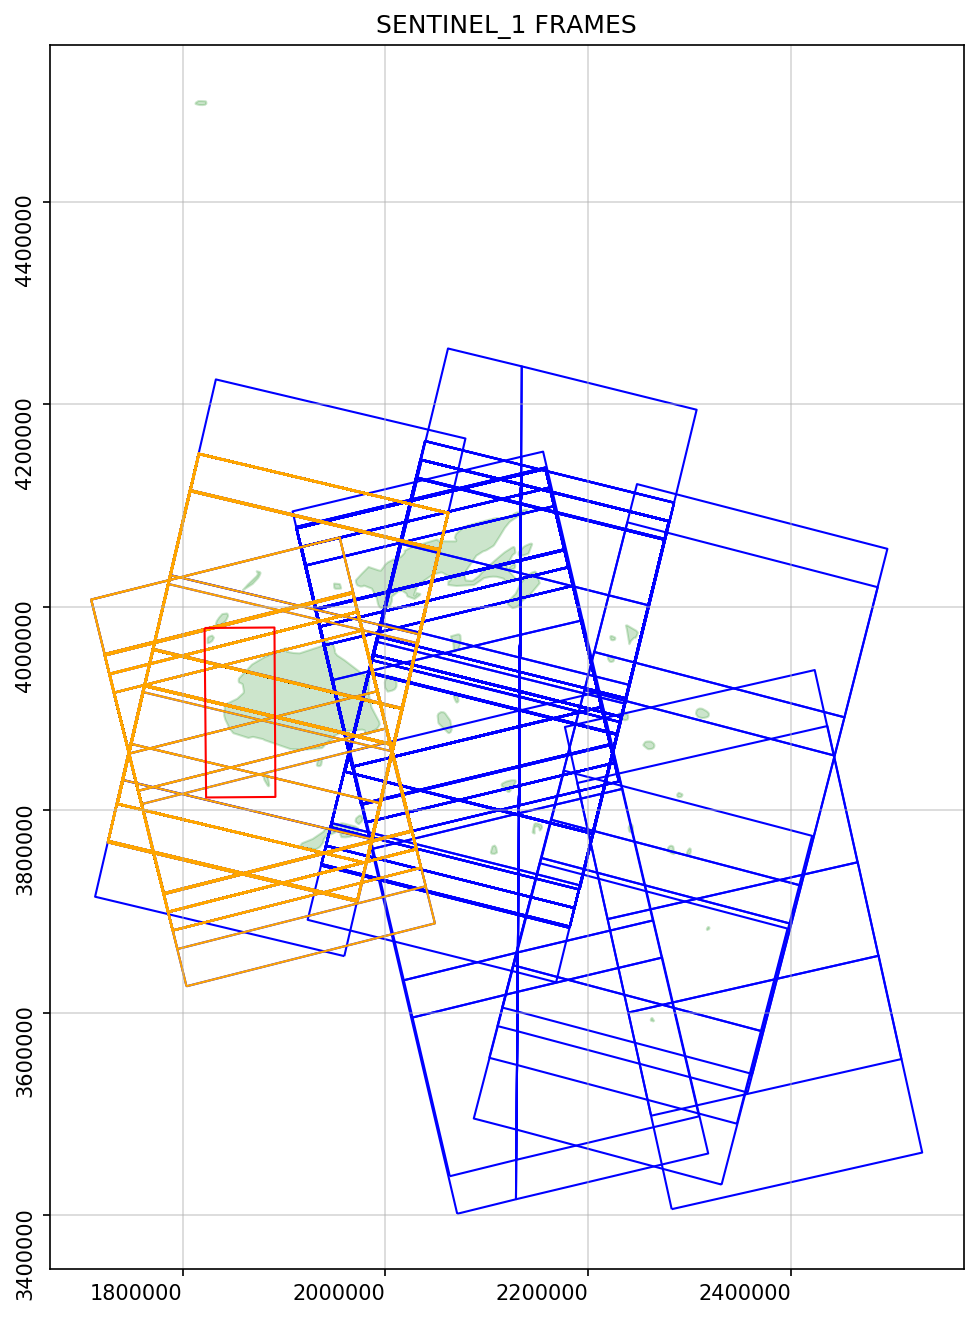

In [103]:
plot_crs = {"init": "epsg:3460"}

# select scenes over mainisland for product development
non_am = "POLYGON((177.07301550947307 -17.17940113068343,177.72120886884807 -17.17940113068343,177.72120886884807 -18.689732935559707,177.07301550947307 -18.689732935559707,177.07301550947307 -17.17940113068343))"
non_am = pd.DataFrame(data={'geometry': [non_am]})
non_am['geometry'] = non_am['geometry'].apply(wkt.loads)
non_am['NAME'] = 'SUB'
non_am = gpd.GeoDataFrame(non_am, geometry='geometry', crs=('epsg:4326'))
non_am.crs = from_epsg(4326)

# intersect non-am subset
non_am_fij = non_am.to_crs({"init": "epsg:3460"})
df_c['des'] = df_c.to_crs({"init": "epsg:3460"}).geometry.map(lambda x: x.intersects(non_am_fij.geometry.any())) # repro and test intersect
df_c_nonam = df_c[df_c['des']==True] # subset



# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

df_c.to_crs(plot_crs).plot(facecolor='',edgecolor='b',ax=ax)

df_c_nonam.to_crs(plot_crs).plot(facecolor='',edgecolor='orange',ax=ax)

non_am.to_crs(plot_crs).plot(facecolor='',edgecolor='r',ax=ax)

ax.set_title('SENTINEL_1 FRAMES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

## CROSS-CHECK AGAINST S3 BUCKET

In [104]:
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/fiji/sentinel_1/'

s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [105]:
yamls[0].split('/')[-2]

'S1A_IW_GRDH_1SDV_20150507T063939'

In [106]:
df_c_nonam['SAC_DONE'] = [ i[:32] in [j.split('/')[-2] for j in yamls] for i in df_c_nonam.title.values ]

In [107]:
df_c_nonam['SAC_DONE'].value_counts()

True     286
False     97
Name: SAC_DONE, dtype: int64

In [108]:
to_do = []
for s, p in zip(df_c_nonam.title.values, df_c_nonam.SAC_DONE):
    if not p:
        to_do.append(s)
len(to_do),to_do[0]

(97, 'S1A_IW_GRDH_1SDV_20200504T064007_20200504T064042_032411_03C0C7_FE9D')

## CREATE JOBLIST

In [109]:
with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S1_nonAM.txt", 'a') as t:
    
    for v in to_do:

        t.write("rpush jobS1"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/sentinel_1/", "ext_dem": "common_sensing/ancillary_products/SRTM1Sec/SRTM30_Fiji_E.tif"'+"}'" + '\n')

# **LANDSAT**

In [493]:
# load world granules
world_granules = gpd.read_file(anc_paths['lstiles_path'][0])
# Create bool for intersection between any tiles - should try inversion to speed up...
for n, g in zip(aoi.NAME, aoi.geometry):
    world_granules[n] = world_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
world_granules[region_name] = world_granules[world_granules[aoi.NAME.values]].any(1)
region_ls_grans = world_granules[world_granules[region_name]==True]

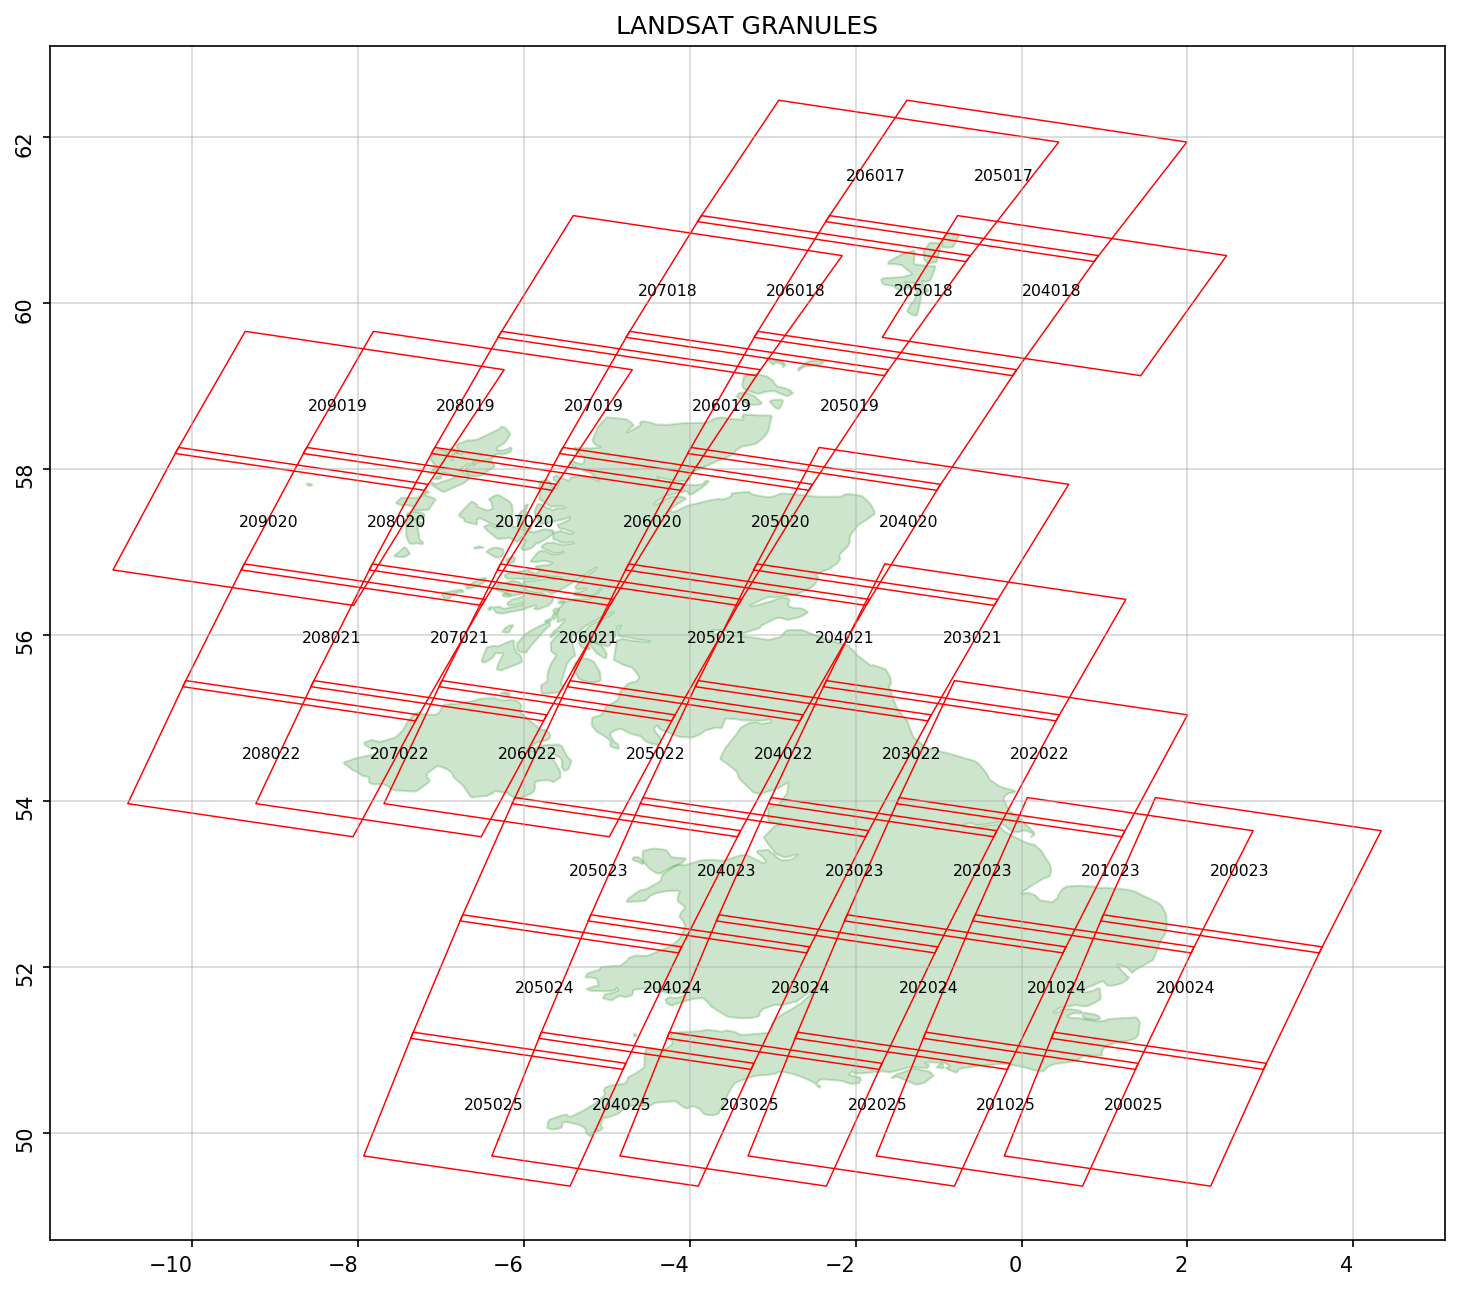

In [494]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

x = region_ls_grans.to_crs(plot_crs).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
region_ls_grans.to_crs(plot_crs).apply(lambda x: ax.annotate(s=x.PR, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

ax.set_title('LANDSAT GRANULES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

In [496]:
pr = region_ls_grans
df = pd.read_csv(anc_paths['ls8csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res3 = df
df = None

In [497]:
df = pd.read_csv(anc_paths['ls7csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res2 = df
df = None

In [498]:
# pr = country_ls_grans
df = pd.read_csv(anc_paths['ls45csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res1 = df
df = None

In [499]:
res3.shape,res2.shape,res1.shape

((12220, 59), (15462, 54), (33619, 50))

In [500]:
res1.columns

Index(['THERMAL_LINES', 'sunAzimuth', 'REFLECTIVE_SAMPLES',
       'upperRightCornerLatitude', 'cloudCover', 'MAP_PROJECTION_L1',
       'cartURL', 'sunElevation', 'path', 'GROUND_CONTROL_POINTS_MODEL', 'row',
       'imageQuality1', 'REFLECTIVE_LINES', 'ELLIPSOID',
       'GEOMETRIC_RMSE_MODEL', 'browseURL', 'browseAvailable', 'dayOrNight',
       'CPF_NAME', 'DATA_TYPE_L1', 'THERMAL_SAMPLES',
       'lowerLeftCornerLatitude', 'sceneStartTime', 'dateUpdated', 'sensor',
       'GROUND_CONTROL_POINTS_VERSION', 'LANDSAT_PRODUCT_ID',
       'acquisitionDate', 'upperRightCornerLongitude',
       'PROCESSING_SOFTWARE_VERSION', 'GRID_CELL_SIZE_REFLECTIVE',
       'lowerRightCornerLongitude', 'lowerRightCornerLatitude',
       'sceneCenterLongitude', 'COLLECTION_CATEGORY',
       'upperLeftCornerLongitude', 'sceneCenterLatitude', 'CLOUD_COVER_LAND',
       'lowerLeftCornerLongitude', 'GEOMETRIC_RMSE_MODEL_X',
       'GEOMETRIC_RMSE_MODEL_Y', 'sceneStopTime', 'upperLeftCornerLatitude',
       

In [513]:

def ls_polys(row):
    return wkt.loads(f"POLYGON (({row.lowerLeftCornerLongitude} {row.lowerLeftCornerLatitude},{row.lowerRightCornerLongitude} {row.lowerRightCornerLatitude},{row.upperRightCornerLongitude} {row.upperRightCornerLatitude},{row.upperLeftCornerLongitude} {row.upperLeftCornerLatitude},{row.lowerLeftCornerLongitude} {row.lowerLeftCornerLatitude}))")
#     return wkt.loads(f"POLYGON (({ll_lat} {ll_lon},{lr_lat} {lr_lon},{ur_lat} {ur_lon},{ul_lat} {ul_lon},{ll_lat} {ll_lon}))")

res1['geometry'] = res1.apply(lambda row: ls_polys(row), axis=1)
res2['geometry'] = res2.apply(lambda row: ls_polys(row), axis=1)
res3['geometry'] = res3.apply(lambda row: ls_polys(row), axis=1)


In [519]:
res1.to_csv("/tmp/data/outputs/SD_20200612_United Kingdom_LS_TM.csv")

In [520]:
res2.to_csv("/tmp/data/outputs/SD_20200612_United Kingdom_LS_ETM.csv")

In [521]:
res3.to_csv("/tmp/data/outputs/SD_20200612_United Kingdom_LS_OLI.csv")

In [514]:
a = gpd.GeoDataFrame(res1, geometry='geometry', crs=('epsg:4326'))

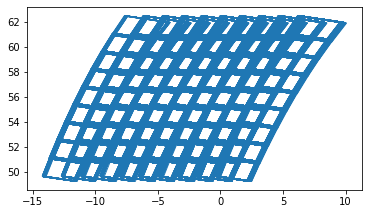

In [515]:
a.plot(facecolor='',edgecolor='C0')

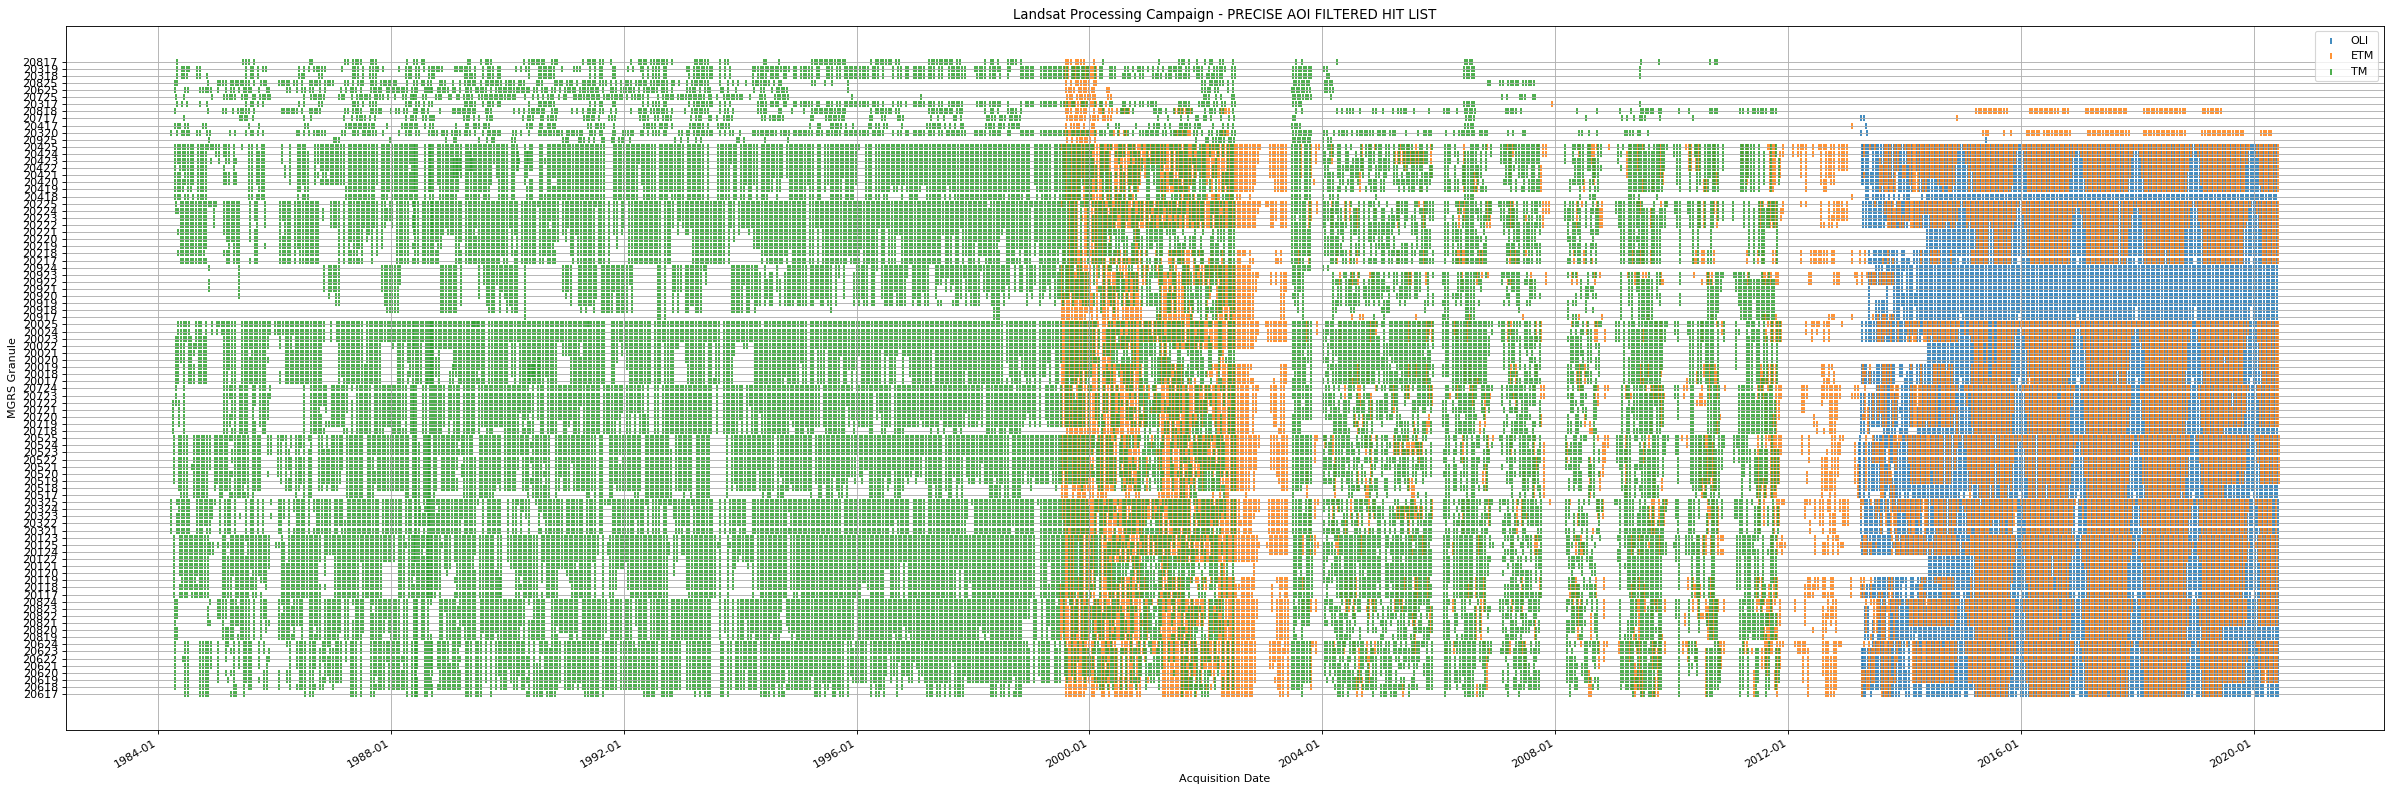

In [66]:
# Plot temporality of L1C and L2A
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = res3
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

df = res2
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

df = res1
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

ax.set_ylabel('MGRS Granule');
ax.set_xlabel("Acquisition Date");
ax.legend(['OLI','ETM','TM','USGS_L1-4MSS']);
ax.set_title("Landsat Processing Campaign - PRECISE AOI FILTERED HIT LIST");
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

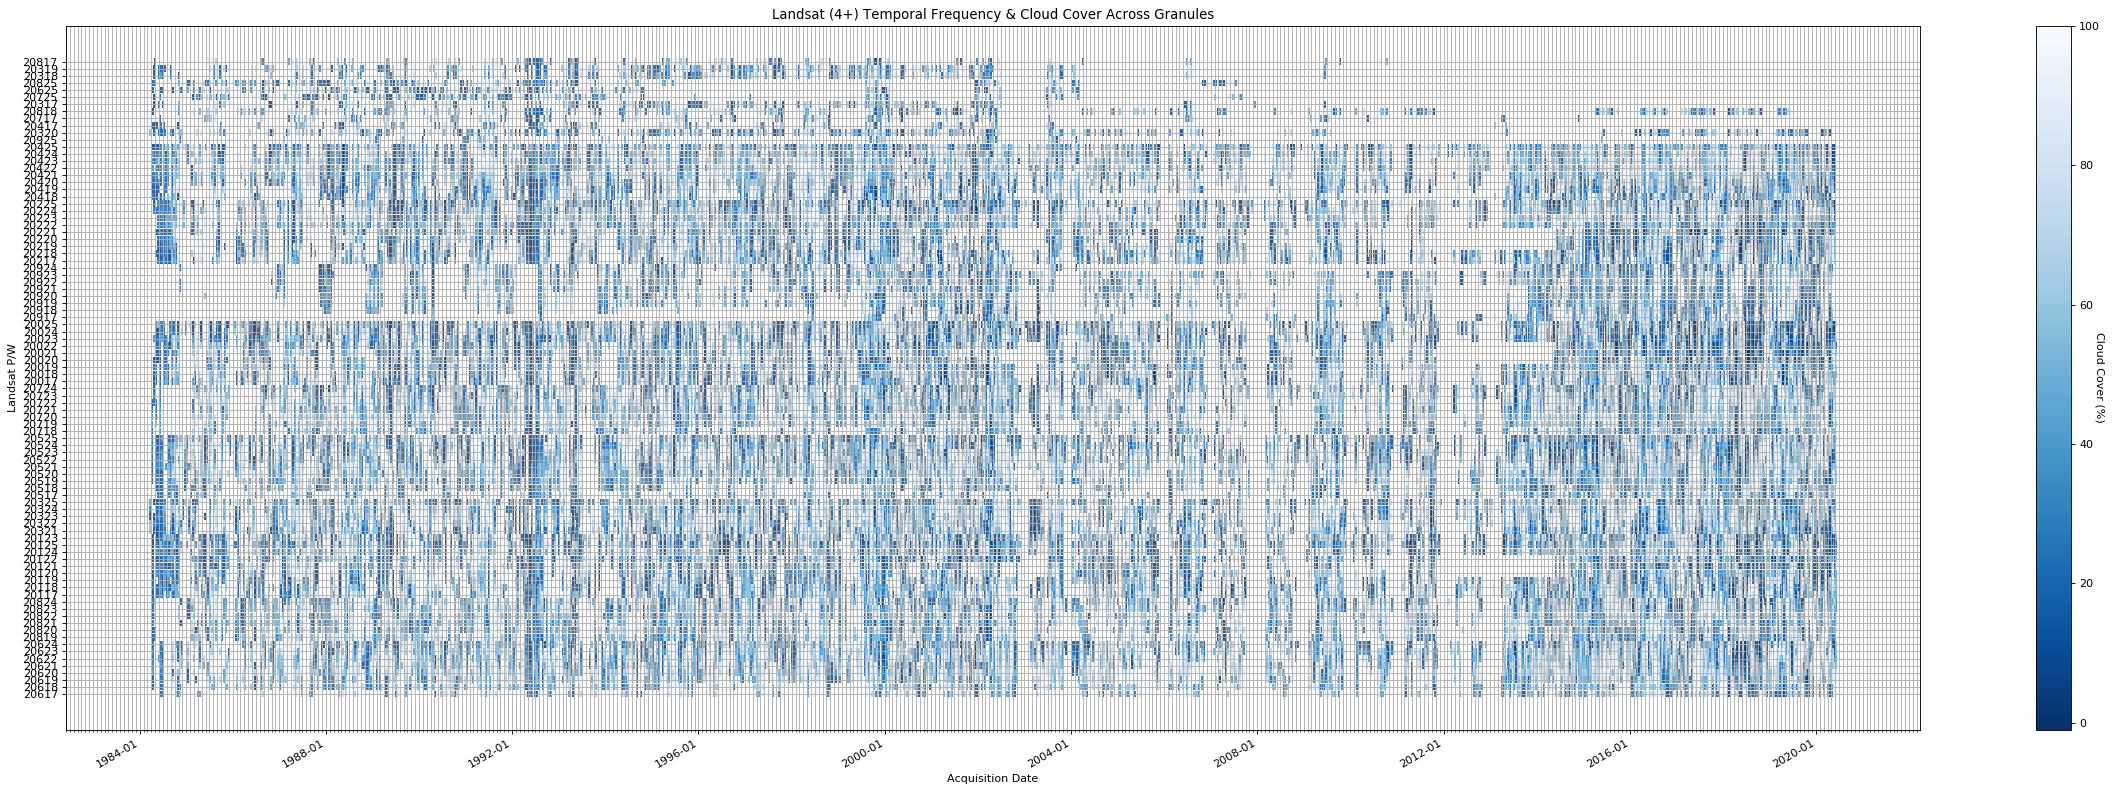

In [61]:
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

# df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_8_C1_fiji.csv')
df = res3
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)

img1 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudCover'].values, cmap='Blues_r');

# df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_ETM_C1_fiji.csv')
df = res2
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)

img2 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudCover'].values, cmap='Blues_r');


# df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_TM_C1_fiji.csv')
df =res1
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)

img3 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudCover'].values, cmap='Blues_r');


cbar = fig.colorbar(img1, ax=ax)
cbar.set_label('Cloud Cover (%)', rotation=270)
ax.set_ylabel("Landsat P/W");
ax.set_xlabel("Acquisition Date");
ax.set_title('Landsat (4+) Temporal Frequency & Cloud Cover Across Granules');
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.xaxis.set_minor_locator(mdates.MonthLocator());
#ax.xaxis.set_minor_formatter(DateFormatter(""%Y-%m"") ); 
ax.grid(which='both')
fig.tight_layout()

#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_polarisation');

In [259]:
res3.shape

(2562, 59)

In [300]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)

In [413]:
# function for basic interaction with ESPA API - hacked together from their 'how to page'
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [416]:
# earth explorer credentials are required
host = 'https://espa.cr.usgs.gov/api/v1/'
#username = 'tom.jones'
#password = 'Welcome12'
username = 'sarah.cheesbrough'
password = 'SaCh_SatApps_USGS1'
# check login
print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp, indent=4))

GET /api/v1/user
200 OK
{
    "email": "Sarah.Cheesbrough@sa.catapult.org.uk",
    "first_name": "Sarah",
    "last_name": "Cheesbrough",
    "roles": [
        "active"
    ],
    "username": "sarah.cheesbrough"
}


In [417]:
## CHECK CONFLICTING ORDERS ###

# check for any existing orders that may prevent imediate processing of a fresh requestttttt
print('GET /api/v1/list-orders')
filters = {"status": ["complete", "ordered"]}  # Here, we ignore any purged orders
resp = espa_api('list-orders', body=filters)
print(json.dumps(resp, indent=4))

GET /api/v1/list-orders
200 OK
[
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061742-988",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061537-204",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061023-761",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-060110-664",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080959-437",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080506-662",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080423-123",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080244-635",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-053952-070"
]


In [331]:
### CHECK PRODUCT AVAILABILITY ###

# example of how to check available products for desired scenes
print('GET /api/v1/available-products')
avail_list = {'inputs': l8_list
             }
resp = espa_api('available-products', body=avail_list)
print(json.dumps(resp, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1GT_076069_20190924_20190925_01_RT",
            "LC08_L1GT_076071_20190924_20190925_01_RT",
            "LC08_L1GT_073069_20190919_20190920_01_RT",
            "LC08_L1TP_073071_20190919_20190920_01_RT",
            "LC08_L1TP_073072_20190919_20190920_01_RT",
            "LC08_L1TP_073073_20190919_20190920_01_RT",
            "LC08_L1GT_075069_20190917_20190918_01_RT",
            "LC08_L1GT_075071_20190917_20190918_01_RT",
            "LC08_L1TP_075072_20190917_20190918_01_RT",
            "LC08_L1TP_075073_20190917_20190918_01_RT",
            "LC08_L1GT_072069_20190912_20190917_01_T2",
            "LC08_L1GT_072071_20190912_20190917_01_T2",
            "LC08_L1TP_072072_20190912_20190917_01_T2",
            "LC08_L1TP_072073_20190912_20190917_01_T1",
            "LC08_L1GT_072074_20190912_20190917_01_T2",
            "LC08_L1GT_074069_20190910_20190917_01_T2",
            "LC

In [313]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)
print(len(l8_list))
er = set(["LC08_L1GT_072069_20160224_20170329_01_T2",
            "LC08_L1GT_072071_20160224_20170329_01_T2",
            "LC08_L1GT_072072_20160224_20170329_01_T2",
            "LC08_L1TP_072073_20160224_20170329_01_T1",
            "LC08_L1GT_072074_20160224_20170329_01_T2",
            "LC08_L1GT_074069_20160222_20170329_01_T2",
            "LC08_L1GT_074071_20160222_20170329_01_T2",
            "LC08_L1TP_074072_20160222_20170329_01_T1",
            "LC08_L1TP_074073_20160222_20170329_01_T1",
            "LC08_L1TP_076069_20160220_20180202_01_T1"])
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
ls = l8_list
#ls = [x (if x is not in er) for x in l8_list]
for i in er: 
    print(i)
    ls.remove(er)
print(len(ls))

2545
LC08_L1TP_076069_20160220_20180202_01_T1


ValueError: list.remove(x): x not in list

In [324]:
### CREATE ORDER ###
# if any further subsetting is required. very recently acquired products are categorised as RT (as opposed to T1/T2). these are of insufficient certainty RE quality to be processed to ARD. this latency is unlikely to impact the non-NRT requirements of Common Sensing.
er = ['LC08_L1GT_072069_20160224_20170329_01_T2', 
      'LC08_L1GT_072071_20160224_20170329_01_T2', 
      'LC08_L1GT_072072_20160224_20170329_01_T2', 
      'LC08_L1TP_072073_20160224_20170329_01_T1', 
      'LC08_L1GT_072074_20160224_20170329_01_T2', 
      'LC08_L1GT_074069_20160222_20170329_01_T2', 
      'LC08_L1GT_074071_20160222_20170329_01_T2', 
      'LC08_L1TP_074072_20160222_20170329_01_T1', 
      'LC08_L1TP_074073_20160222_20170329_01_T1', 
      'LC08_L1TP_076069_20160220_20180202_01_T1'
     ]
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
l8_ls = [e for e in l8_list if e not in (er)]
l8_ls = [i for i in l8_list if 'RT' not in i]

# specifying differing products across the sensors
l8_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
         
# determine available-products under their respective sensors
ls = l8_ls
print('GET /api/v1/available-products')
order = espa_api('available-products', body=dict(inputs=ls))
print(json.dumps(order, indent=4))

# replace available products with what we wish to process
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):

        if set(l8_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l8_prods

# Add in the rest of the order information
#order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'DY Veg'

# the order shoud now have changed from the original call available-products
print(json.dumps(order, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1GT_072069_20190912_20190917_01_T2",
            "LC08_L1GT_072071_20190912_20190917_01_T2",
            "LC08_L1TP_072072_20190912_20190917_01_T2",
            "LC08_L1TP_072073_20190912_20190917_01_T1",
            "LC08_L1GT_072074_20190912_20190917_01_T2",
            "LC08_L1GT_074069_20190910_20190917_01_T2",
            "LC08_L1TP_074071_20190910_20190917_01_T1",
            "LC08_L1TP_074072_20190910_20190917_01_T1",
            "LC08_L1TP_074073_20190910_20190917_01_T1",
            "LC08_L1GT_076069_20190908_20190917_01_T2",
            "LC08_L1GT_076071_20190908_20190917_01_T2",
            "LC08_L1GT_073069_20190903_20190917_01_T2",
            "LC08_L1GT_073071_20190903_20190917_01_T2",
            "LC08_L1GT_073072_20190903_20190917_01_T2",
            "LC08_L1GT_073073_20190903_20190917_01_T2",
            "LC08_L1GT_075069_20190901_20190916_01_T2",
            "LC

In [325]:
order['date_restricted']

{'sr_ndmi': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'LC08_L1GT_072071_20160224_20170329_01_T2',
  'LC08_L1GT_072072_20160224_20170329_01_T2',
  'LC08_L1TP_072073_20160224_20170329_01_T1',
  'LC08_L1GT_072074_20160224_20170329_01_T2',
  'LC08_L1GT_074069_20160222_20170329_01_T2',
  'LC08_L1GT_074071_20160222_20170329_01_T2',
  'LC08_L1TP_074072_20160222_20170329_01_T1',
  'LC08_L1TP_074073_20160222_20170329_01_T1',
  'LC08_L1TP_076069_20160220_20180202_01_T1'],
 'sr_savi': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'LC08_L1GT_072071_20160224_20170329_01_T2',
  'LC08_L1GT_072072_20160224_20170329_01_T2',
  'LC08_L1TP_072073_20160224_20170329_01_T1',
  'LC08_L1GT_072074_20160224_20170329_01_T2',
  'LC08_L1GT_074069_20160222_20170329_01_T2',
  'LC08_L1GT_074071_20160222_20170329_01_T2',
  'LC08_L1TP_074072_20160222_20170329_01_T1',
  'LC08_L1TP_074073_20160222_20170329_01_T1',
  'LC08_L1TP_076069_20160220_20180202_01_T1'],
 'sr': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'L

In [326]:
order.keys()
order.pop('date_restricted')
order.pop('oli8_collection')

{'inputs': ['LO08_L1GT_075069_20150210_20170413_01_T2',
  'LO08_L1GT_075071_20150210_20170413_01_T2',
  'LO08_L1TP_075072_20150210_20170413_01_T1',
  'LO08_L1TP_075073_20150210_20170413_01_T1'],
 'products': ['sr',
  'bt',
  'source_metadata',
  'sr_ndvi',
  'sr_evi',
  'sr_savi',
  'sr_msavi',
  'sr_ndmi',
  'sr_nbr',
  'sr_nbr2',
  'stats',
  'pixel_qa']}

In [327]:
### PLACE ORDER ###
print('POST /api/v1/order')
resp = espa_api('order', verb='post', body=order)
print(resp.keys)
print(json.dumps(resp, indent=4))

POST /api/v1/order
400 BAD REQUEST
{
    "errors": [
        {
            "8 validation errors": [
                "Requested sr_ndmi products are restricted by date. Remove olitirs8_collection scenes: [u'LC08_L1GT_072069_20160224_20170329_01_T2', u'LC08_L1GT_072071_20160224_20170329_01_T2', u'LC08_L1GT_072072_20160224_20170329_01_T2', u'LC08_L1TP_072073_20160224_20170329_01_T1', u'LC08_L1GT_072074_20160224_20170329_01_T2', u'LC08_L1GT_074069_20160222_20170329_01_T2', u'LC08_L1GT_074071_20160222_20170329_01_T2', u'LC08_L1TP_074072_20160222_20170329_01_T1', u'LC08_L1TP_074073_20160222_20170329_01_T1', u'LC08_L1TP_076069_20160220_20180202_01_T1']",
                "Requested sr_savi products are restricted by date. Remove olitirs8_collection scenes: [u'LC08_L1GT_072069_20160224_20170329_01_T2', u'LC08_L1GT_072071_20160224_20170329_01_T2', u'LC08_L1GT_072072_20160224_20170329_01_T2', u'LC08_L1TP_072073_20160224_20170329_01_T1', u'LC08_L1GT_072074_20160224_20170329_01_T2', u'LC08_L1GT_074

AttributeError: 'NoneType' object has no attribute 'keys'

# **SENTINEL-3** via sentinelsat

In [15]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [142]:
# l2a results
res = esa_api.query(aoi_wkt, platformname='Sentinel-3',producttype='SY_2_SYN___')
esa_s3 = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 3437/3437 [00:56<00:00, 61.04 products/s]


In [143]:
esa_s3.to_csv("/tmp/data/outputs/SD_20200611_United Kingdom_S3_SY_2_SYN___.csv")

# **OTHER USGS**

Login & grab token

In [56]:
token_req = {
        "jsonRequest": json.dumps({
            "username": os.environ['USGS_USERNAME'],
            "password": os.environ['USGS_PWD'],
            "authType": "",
            "catalogId": 'EE'
        })
    }
r = requests.post(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/login', data=token_req)
token = json.loads(r.text)['data']
token

'eac7d21d16404da6bbdde39d6696152b'

# **Get Datasets Lists** 
Need the exact product codes or all datasets searchable via API. These appear to be poorly documented elsewhere. 

In [215]:
request_code = "datasets"

json_request_content = json.dumps({
    "apiKey": token
})

In [217]:
%%time
r = requests.get(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/{request_code}?jsonRequest={json_request_content}', verify=False)
datasets = r

CPU times: user 13.3 ms, sys: 3.37 ms, total: 16.7 ms
Wall time: 36.1 s


In [231]:
dss = pd.DataFrame(json.loads(r.text)['data'])
dss.to_csv('/tmp/data/outputs/usgsdatasets.csv')
dss.head(2)

bounds        datasetName  \
0  {'north': 72.0098, 'east': 176.9874, 'south': ...     LANDSAT_ETM_C1   
1  {'north': 85, 'east': -179.99, 'south': -85, '...  MODIS_MCD43D28_V6   

                                     datasetFullName datasetShortName  \
0   Landsat 7 Enhanced Thematic Mapper Plus Colle...             None   
1   MCD43D28: MODIS/Terra and Aqua BRDF/Albedo Pa...             None   

               idnEntryId     endDate   startDate lastModifiedDate  \
0  Landsat7_ETM_Plus_C1_1  2020-06-09  1999-05-28       2020-06-09   
1                          2020-05-19  2000-02-16       2020-06-09   

   supportDownload  supportBulkDownload  bulkDownloadOrderLimit  \
0             True                 True                   15000   
1             True                False                       0   

   supportCloudCover supportDeletionSearch  supportOrder  orderLimit  \
0               True                  None          True         500   
1              False                  None         False           0   

   totalScenes  
0      2821266  
1         7397

# **MODIS First** 
MODIS_MCD43A4_V6 seems most useful product due to having BRDF already applied. Iterate years to satisfy req reqs.

In [327]:
prod = 'MODIS_MCD43A4_V6'
request_code = 'search'

In [379]:
def create_search_request(prod, aoi, t1, t2):
    
    return json.dumps({
        "datasetName": prod,
            "spatialFilter": {
                "filterType": "mbr",
                "lowerLeft": {
                    "latitude": aoi.bounds.miny.values[0],
                    "longitude": aoi.bounds.minx.values[0]
                },
                "upperRight": {
                    "latitude": aoi.bounds.maxy.values[0],
                    "longitude": aoi.bounds.maxx.values[0] 
                }
            },
            "temporalFilter": {
                "startDate": t1, #"2006-01-01",
                "endDate": t2, #"2007-12-01"
            },
        "maxResults": 49000,
        "startingNumber": 1,
        "sortOrder": "ASC",
        "apiKey": token
    })
    

In [380]:

res = []
for yr in tqdm(range(1990,2020)):
    t1 = f'{yr}-01-01'
    t2 = f'{yr}-12-31'
    try:
        r = requests.get(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/{request_code}?jsonRequest={create_search_request(prod, aoi, t1, t2)}')
        res.append(json.loads(r.text))
        print(yr, 'woop')
    except:
        print('boo')
#     res.append(json.loads(, verify=False).text)['data']['results'])
#     except Exception as e:
#         print(e)
#         break


  3%|▎         | 1/30 [01:00<29:27, 60.95s/it]

1990 woop


  7%|▋         | 2/30 [01:56<27:39, 59.26s/it]

1991 woop


 10%|█         | 3/30 [02:49<25:51, 57.48s/it]

1992 woop


 13%|█▎        | 4/30 [03:38<23:45, 54.83s/it]

1993 woop


 17%|█▋        | 5/30 [04:30<22:29, 54.00s/it]

1994 woop


 20%|██        | 6/30 [05:22<21:24, 53.53s/it]

1995 woop


 23%|██▎       | 7/30 [06:15<20:24, 53.25s/it]

1996 woop


 27%|██▋       | 8/30 [07:06<19:20, 52.76s/it]

1997 woop


 30%|███       | 9/30 [07:57<18:14, 52.10s/it]

1998 woop


 33%|███▎      | 10/30 [08:50<17:24, 52.22s/it]

1999 woop


 37%|███▋      | 11/30 [09:58<18:04, 57.08s/it]

2000 woop


 40%|████      | 12/30 [11:22<19:34, 65.25s/it]

2001 woop


 43%|████▎     | 13/30 [12:35<19:09, 67.63s/it]

2002 woop


 47%|████▋     | 14/30 [13:48<18:27, 69.24s/it]

2003 woop


 50%|█████     | 15/30 [15:01<17:31, 70.11s/it]

2004 woop


 53%|█████▎    | 16/30 [16:19<16:55, 72.57s/it]

2005 woop


 57%|█████▋    | 17/30 [17:48<16:46, 77.44s/it]

2006 woop


 60%|██████    | 18/30 [19:13<15:57, 79.79s/it]

2007 woop


 63%|██████▎   | 19/30 [20:41<15:04, 82.23s/it]

2008 woop


 67%|██████▋   | 20/30 [22:03<13:40, 82.05s/it]

2009 woop


 70%|███████   | 21/30 [23:19<12:02, 80.30s/it]

2010 woop


 73%|███████▎  | 22/30 [24:30<10:21, 77.69s/it]

2011 woop


 77%|███████▋  | 23/30 [25:50<09:07, 78.18s/it]

2012 woop


 80%|████████  | 24/30 [27:09<07:50, 78.45s/it]

2013 woop


 83%|████████▎ | 25/30 [28:25<06:28, 77.67s/it]

2014 woop


 87%|████████▋ | 26/30 [29:34<05:00, 75.22s/it]

2015 woop


 90%|█████████ | 27/30 [30:57<03:52, 77.66s/it]

2016 woop


 93%|█████████▎| 28/30 [32:19<02:37, 78.76s/it]

2017 woop


 97%|█████████▋| 29/30 [33:41<01:19, 79.78s/it]

2018 woop


100%|██████████| 30/30 [34:58<00:00, 69.95s/it]

2019 woop


collate responses into df, add geometry and save to csv

In [414]:
modis = []
for i in res:
    modis.append(pd.DataFrame(i['data']['results']))
modis = pd.concat(modis)
modis.shape

(45349, 18)

In [415]:
modis['geometry'] = [shape(i) for i in modis.spatialFootprint.values]

In [416]:
m = gpd.GeoDataFrame(modis, geometry='geometry', crs=('epsg:4326'))

In [417]:
modis.to_csv("/tmp/data/outputs/SD_20200611_United Kingdom_MODIS_MCD43A4_V6.csv")

In [16]:
modcsv = pd.read_csv('/tmp/data/outputs/SD_20200611_United Kingdom_MODIS_MCD43A4_V6.csv')

In [18]:
print(modcsv.columns)
modcsv.head(2)

Index(['Unnamed: 0', 'acquisitionDate', 'startTime', 'endTime',
       'spatialFootprint', 'sceneBounds', 'browseUrl', 'dataAccessUrl',
       'downloadUrl', 'entityId', 'displayId', 'cloudCover', 'metadataUrl',
       'fgdcMetadataUrl', 'modifiedDate', 'orderUrl', 'bulkOrdered', 'ordered',
       'summary', 'geometry'],
      dtype='object')


Unnamed: 0 acquisitionDate   startTime     endTime  \
0           0      2000-02-16  2000-02-16  2000-03-03   
1           1      2000-02-16  2000-02-16  2000-03-03   

                                    spatialFootprint  \
0  {'type': 'Polygon', 'coordinates': [[[0.0009, ...   
1  {'type': 'Polygon', 'coordinates': [[[-13.0258...   

                       sceneBounds  \
0  -0.0348,59.6252,29.2702,70.0158   
1  -15.5572,39.8151,0.0216,50.0062   

                                           browseUrl  \
0  https://ims.cr.usgs.gov/browse/modis/mcd43a4_v...   
1  https://ims.cr.usgs.gov/browse/modis/mcd43a4_v...   

                                       dataAccessUrl  \
0  https://earthexplorer.usgs.gov/order/process?d...   
1  https://earthexplorer.usgs.gov/order/process?d...   

                                         downloadUrl    entityId  \
0  https://earthexplorer.usgs.gov/download/extern...  2217526348   
1  https://earthexplorer.usgs.gov/download/extern...  2217527011   

                     displayId  cloudCover  \
0  MCD43A4.A2000055.h18v02.006         NaN   
1  MCD43A4.A2000055.h17v04.006         NaN   

                                         metadataUrl  \
0  https://earthexplorer.usgs.gov/metadata/xml/12...   
1  https://earthexplorer.usgs.gov/metadata/xml/12...   

                                     fgdcMetadataUrl modifiedDate  orderUrl  \
0  https://earthexplorer.usgs.gov/fgdc/12723/2217...   2016-10-21       NaN   
1  https://earthexplorer.usgs.gov/fgdc/12723/2217...   2016-10-21       NaN   

   bulkOrdered  ordered                                            summary  \
0        False    False  Entity ID: MCD43A4.A2000055.h18v02.006.2016101...   
1        False    False  Entity ID: MCD43A4.A2000055.h17v04.006.2016101...   

                                            geometry  
0  POLYGON ((0.0009 59.6252, 19.8281 59.6255, 29....  
1  POLYGON ((-13.0258 39.8151, 0.0107 39.8191, 0....

In [52]:
modcsv.head(1).summary.values

array(['Entity ID: MCD43A4.A2000055.h18v02.006.2016101151508.hdf, Coordinates: 65.15 , 12.4144, Acquisition Date: 16-FEB-00, Category: MODIS BRDF and Albedo'],
      dtype=object)

In [60]:
request_code = "download"

payload = json.dumps({
    "datasetName": "MODIS_MCD43A4_V6",
    "node": "EE",
    "apiKey": token,
    "entityIds": ['2217526348']
})


down_req = {
        "jsonRequest": json.dumps({
            "datasetName": "MODIS_MCD43A4_V6",
            "node": "EE",
            "apiKey": token,
            "entityIds": ['2217526348']
        })
    }

In [61]:
%%time
r = requests.post(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/download', data=down_req)

CPU times: user 15.2 ms, sys: 945 µs, total: 16.2 ms
Wall time: 544 ms


In [62]:
r.content

b'{"errorCode":"AUTH_UNAUTHORIZED","error":"Forbidden - Approved role required for access to \'download\' method.","data":null,"api_version":"1.4.0","access_level":"user","catalog_id":"EE","executionTime":0.03901815414428711}'

In [63]:
url = "https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/6/MCD43A4/2020/008/MCD43A4.A2020008.h00v08.006.2020017034128.hdf"

In [78]:
import requests

app_key = "F686BDAA-AFF6-11EA-A286-BD6627C29E35"

url = "https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/6/MCD43A4/2020/008/MCD43A4.A2020008.h00v08.006.2020017034128.hdf"
headers = {}
headers['Authorisation'] = f"Bearer {app_key}"
r = requests.get(url, headers=headers)
# down_req = {
#         "jsonRequest": json.dumps({
#             "Authorization": f"{app_key}",
#         })
#     }
# r = requests.post(url, data=down_req)

In [82]:
filename = '/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf'

with open(filename, mode='wb') as localfile:     
    localfile.write(r.content)

In [66]:
resp.content

b'<!DOCTYPE html>\n<!--[if lt IE 7]><html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\n<!--[if IE 7]><html class="no-js lt-ie9 lt-ie8"> <![endif]-->\n<!--[if IE 8]><html class="no-js lt-ie9"> <![endif]-->\n<!--[if gt IE 8]><!--><html lang="en" class="no-js"><!--<![endif]-->\n  <head>\n    <meta charset="utf-8">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n    <title>Earthdata Login</title>\n    <meta name="description" content="Earthdata Login">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n\n    <!-- Google Tag Manager -->\n    <script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push(\n\n      {\'gtm.start\': new Date().getTime(),event:\'gtm.js\'}\n\n    );var f=d.getElementsByTagName(s)[0],\n      j=d.createElement(s),dl=l!=\'dataLayer\'?\'&l=\'+l:\'\';j.async=true;j.src=\n      \'https://www.googletagmanager.com/gtm.js?id=\'+i+dl;f.parentNode.insertBefore(j,f);\n    })(window,document,\'script\',\'dataLayer\',\'GTM-WNP7MLF\');<

# **ASTER** 
ASTER_L1T looks best - remembering sparse availability

In [419]:
prod = 'ASTER_L1T'
request_code = 'search'

In [420]:
def create_search_request(prod, aoi, t1, t2):
    
    return json.dumps({
        "datasetName": prod,
            "spatialFilter": {
                "filterType": "mbr",
                "lowerLeft": {
                    "latitude": aoi.bounds.miny.values[0],
                    "longitude": aoi.bounds.minx.values[0]
                },
                "upperRight": {
                    "latitude": aoi.bounds.maxy.values[0],
                    "longitude": aoi.bounds.maxx.values[0] 
                }
            },
            "temporalFilter": {
                "startDate": t1, #"2006-01-01",
                "endDate": t2, #"2007-12-01"
            },
        "maxResults": 49000,
        "startingNumber": 1,
        "sortOrder": "ASC",
        "apiKey": token
    })
    

In [421]:

res = []
for yr in tqdm(range(1990,2020)):
    t1 = f'{yr}-01-01'
    t2 = f'{yr}-12-31'
    try:
        r = requests.get(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/{request_code}?jsonRequest={create_search_request(prod, aoi, t1, t2)}')
        res.append(json.loads(r.text))
        print(yr, 'woop')
    except:
        print('boo')
#     res.append(json.loads(, verify=False).text)['data']['results'])
#     except Exception as e:
#         print(e)
#         break


  3%|▎         | 1/30 [00:01<00:56,  1.95s/it]

1990 woop


  7%|▋         | 2/30 [00:03<00:53,  1.93s/it]

1991 woop


 10%|█         | 3/30 [00:05<00:49,  1.82s/it]

1992 woop


 13%|█▎        | 4/30 [00:06<00:44,  1.71s/it]

1993 woop


 17%|█▋        | 5/30 [00:08<00:41,  1.66s/it]

1994 woop


 20%|██        | 6/30 [00:09<00:37,  1.58s/it]

1995 woop


 23%|██▎       | 7/30 [00:11<00:35,  1.53s/it]

1996 woop


 27%|██▋       | 8/30 [00:12<00:33,  1.52s/it]

1997 woop


 30%|███       | 9/30 [00:14<00:31,  1.48s/it]

1998 woop


 33%|███▎      | 10/30 [00:15<00:29,  1.47s/it]

1999 woop


 37%|███▋      | 11/30 [00:23<01:04,  3.39s/it]

2000 woop


 40%|████      | 12/30 [00:32<01:34,  5.25s/it]

2001 woop


 43%|████▎     | 13/30 [00:43<01:54,  6.75s/it]

2002 woop


 47%|████▋     | 14/30 [00:54<02:09,  8.08s/it]

2003 woop


 50%|█████     | 15/30 [01:04<02:09,  8.65s/it]

2004 woop


 53%|█████▎    | 16/30 [01:13<02:03,  8.79s/it]

2005 woop


 57%|█████▋    | 17/30 [01:20<01:48,  8.37s/it]

2006 woop


 60%|██████    | 18/30 [01:30<01:43,  8.65s/it]

2007 woop


 63%|██████▎   | 19/30 [01:38<01:34,  8.55s/it]

2008 woop


 67%|██████▋   | 20/30 [01:43<01:14,  7.42s/it]

2009 woop


 70%|███████   | 21/30 [01:46<00:54,  6.11s/it]

2010 woop


 73%|███████▎  | 22/30 [01:49<00:41,  5.17s/it]

2011 woop


 77%|███████▋  | 23/30 [01:51<00:30,  4.33s/it]

2012 woop


 80%|████████  | 24/30 [02:00<00:34,  5.82s/it]

2013 woop


 83%|████████▎ | 25/30 [02:08<00:32,  6.46s/it]

2014 woop


 87%|████████▋ | 26/30 [02:16<00:26,  6.65s/it]

2015 woop


 90%|█████████ | 27/30 [02:24<00:21,  7.32s/it]

2016 woop


 93%|█████████▎| 28/30 [02:34<00:16,  8.14s/it]

2017 woop


 97%|█████████▋| 29/30 [02:45<00:08,  8.91s/it]

2018 woop


100%|██████████| 30/30 [02:52<00:00,  5.76s/it]

2019 woop


collate responses into df, add geometry and save to csv

In [423]:
aster = []
for i in res:
    aster.append(pd.DataFrame(i['data']['results']))
aster = pd.concat(aster)
aster.shape

(13783, 18)

In [424]:
aster['geometry'] = [shape(i) for i in aster.spatialFootprint.values]

In [425]:
m = gpd.GeoDataFrame(aster, geometry='geometry', crs=('epsg:4326'))

In [437]:
aster.to_csv("/tmp/data/outputs/SD_20200611_United Kingdom_ASTER_L1T.csv")

# **AVHRR** 

In [481]:
prod = 'AVHRR_1K_GLOBAL_COMP'
request_code = 'search'

In [482]:
def create_search_request(prod, aoi, t1, t2):
    
    return json.dumps({
        "datasetName": prod,
            "spatialFilter": {
                "filterType": "mbr",
                "lowerLeft": {
                    "latitude": aoi.bounds.miny.values[0],
                    "longitude": aoi.bounds.minx.values[0]
                },
                "upperRight": {
                    "latitude": aoi.bounds.maxy.values[0],
                    "longitude": aoi.bounds.maxx.values[0] 
                }
            },
            "temporalFilter": {
                "startDate": t1, #"2006-01-01",
                "endDate": t2, #"2007-12-01"
            },
        "maxResults": 49000,
        "startingNumber": 1,
        "sortOrder": "ASC",
        "apiKey": token
    })
    

In [483]:

res = []
for yr in tqdm(range(1990,2020)):
    t1 = f'{yr}-01-01'
    t2 = f'{yr}-12-31'
    try:
        r = requests.get(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/{request_code}?jsonRequest={create_search_request(prod, aoi, t1, t2)}')
        res.append(json.loads(r.text))
        print(yr, 'woop')
    except:
        print('boo')
#     res.append(json.loads(, verify=False).text)['data']['results'])
#     except Exception as e:
#         print(e)
#         break


  3%|▎         | 1/30 [00:01<00:36,  1.26s/it]

1990 woop


  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]

1991 woop


 10%|█         | 3/30 [00:03<00:32,  1.19s/it]

1992 woop


 13%|█▎        | 4/30 [00:04<00:31,  1.22s/it]

1993 woop


 17%|█▋        | 5/30 [00:05<00:28,  1.14s/it]

1994 woop


 20%|██        | 6/30 [00:07<00:29,  1.23s/it]

1995 woop


 23%|██▎       | 7/30 [00:08<00:26,  1.16s/it]

1996 woop


 27%|██▋       | 8/30 [00:09<00:25,  1.17s/it]

1997 woop


 30%|███       | 9/30 [00:10<00:23,  1.11s/it]

1998 woop


 33%|███▎      | 10/30 [00:11<00:21,  1.06s/it]

1999 woop


 37%|███▋      | 11/30 [00:12<00:19,  1.04s/it]

2000 woop


 40%|████      | 12/30 [00:13<00:18,  1.02s/it]

2001 woop


 43%|████▎     | 13/30 [00:14<00:18,  1.07s/it]

2002 woop


 47%|████▋     | 14/30 [00:15<00:16,  1.04s/it]

2003 woop


 50%|█████     | 15/30 [00:16<00:15,  1.04s/it]

2004 woop


 53%|█████▎    | 16/30 [00:17<00:14,  1.02s/it]

2005 woop


 57%|█████▋    | 17/30 [00:18<00:12,  1.00it/s]

2006 woop


 60%|██████    | 18/30 [00:19<00:11,  1.02it/s]

2007 woop


 63%|██████▎   | 19/30 [00:20<00:10,  1.03it/s]

2008 woop


 67%|██████▋   | 20/30 [00:21<00:09,  1.06it/s]

2009 woop


 70%|███████   | 21/30 [00:22<00:08,  1.07it/s]

2010 woop


 73%|███████▎  | 22/30 [00:22<00:07,  1.06it/s]

2011 woop


 77%|███████▋  | 23/30 [00:23<00:06,  1.06it/s]

2012 woop


 80%|████████  | 24/30 [00:24<00:05,  1.08it/s]

2013 woop


 83%|████████▎ | 25/30 [00:25<00:04,  1.08it/s]

2014 woop


 87%|████████▋ | 26/30 [00:26<00:03,  1.09it/s]

2015 woop


 90%|█████████ | 27/30 [00:27<00:02,  1.09it/s]

2016 woop


 93%|█████████▎| 28/30 [00:28<00:01,  1.08it/s]

2017 woop


 97%|█████████▋| 29/30 [00:29<00:00,  1.09it/s]

2018 woop


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]

2019 woop


collate responses into df, add geometry and save to csv

In [484]:
avhrr = []
for i in res:
    avhrr.append(pd.DataFrame(i['data']['results']))
avhrr = pd.concat(avhrr)
avhrr.shape

(93, 18)

In [485]:
avhrr['geometry'] = [shape(i) for i in avhrr.spatialFootprint.values]

In [486]:
m = gpd.GeoDataFrame(avhrr, geometry='geometry', crs=('epsg:4326'))

In [487]:
avhrr.to_csv("/tmp/data/outputs/SD_20200611_United Kingdom_AVHRR_1K_GLOBAL_COMP.csv")

In [489]:
m.downloadUrl.values

array(['https://earthexplorer.usgs.gov/download/external/options/AVHRR_1K_GLOBAL_COMP/AG1KM11199204010410/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/AVHRR_1K_GLOBAL_COMP/AG1KM11199204110420/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/AVHRR_1K_GLOBAL_COMP/AG1KM11199204210430/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/AVHRR_1K_GLOBAL_COMP/AG1KM11199205010510/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/AVHRR_1K_GLOBAL_COMP/AG1KM11199205110520/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/AVHRR_1K_GLOBAL_COMP/AG1KM11199205210530/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/AVHRR_1K_GLOBAL_COMP/AG1KM11199206010610/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/AVHRR_1K_GLOBAL_COMP/AG1KM11199206110620/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/AVHRR_1

# **VIIRS** 8-day 500m L3

In [452]:
prod = 'VIIRS_VNP09H1'
request_code = 'search'

In [453]:
def create_search_request(prod, aoi, t1, t2):
    
    return json.dumps({
        "datasetName": prod,
            "spatialFilter": {
                "filterType": "mbr",
                "lowerLeft": {
                    "latitude": aoi.bounds.miny.values[0],
                    "longitude": aoi.bounds.minx.values[0]
                },
                "upperRight": {
                    "latitude": aoi.bounds.maxy.values[0],
                    "longitude": aoi.bounds.maxx.values[0] 
                }
            },
            "temporalFilter": {
                "startDate": t1, #"2006-01-01",
                "endDate": t2, #"2007-12-01"
            },
        "maxResults": 49000,
        "startingNumber": 1,
        "sortOrder": "ASC",
        "apiKey": token
    })
    

In [454]:

res = []
for yr in tqdm(range(1990,2020)):
    t1 = f'{yr}-01-01'
    t2 = f'{yr}-12-31'
    try:
        r = requests.get(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/{request_code}?jsonRequest={create_search_request(prod, aoi, t1, t2)}')
        res.append(json.loads(r.text))
        print(yr, 'woop')
    except:
        print('boo')
#     res.append(json.loads(, verify=False).text)['data']['results'])
#     except Exception as e:
#         print(e)
#         break


  3%|▎         | 1/30 [00:10<05:12, 10.76s/it]

1990 woop


  7%|▋         | 2/30 [00:18<04:35,  9.84s/it]

1991 woop


 10%|█         | 3/30 [00:25<04:06,  9.14s/it]

1992 woop


 13%|█▎        | 4/30 [00:33<03:41,  8.54s/it]

1993 woop


 17%|█▋        | 5/30 [00:40<03:22,  8.09s/it]

1994 woop


 20%|██        | 6/30 [00:47<03:05,  7.73s/it]

1995 woop


 23%|██▎       | 7/30 [00:54<02:54,  7.60s/it]

1996 woop


 27%|██▋       | 8/30 [01:01<02:47,  7.60s/it]

1997 woop


 30%|███       | 9/30 [01:09<02:38,  7.53s/it]

1998 woop


 33%|███▎      | 10/30 [01:16<02:29,  7.48s/it]

1999 woop


 37%|███▋      | 11/30 [01:23<02:20,  7.38s/it]

2000 woop


 40%|████      | 12/30 [01:31<02:11,  7.33s/it]

2001 woop


 43%|████▎     | 13/30 [01:38<02:03,  7.26s/it]

2002 woop


 47%|████▋     | 14/30 [01:45<01:57,  7.35s/it]

2003 woop


 50%|█████     | 15/30 [01:52<01:48,  7.22s/it]

2004 woop


 53%|█████▎    | 16/30 [01:59<01:41,  7.28s/it]

2005 woop


 57%|█████▋    | 17/30 [02:07<01:34,  7.29s/it]

2006 woop


 60%|██████    | 18/30 [02:14<01:28,  7.35s/it]

2007 woop


 63%|██████▎   | 19/30 [02:21<01:20,  7.29s/it]

2008 woop


 67%|██████▋   | 20/30 [02:29<01:13,  7.30s/it]

2009 woop


 70%|███████   | 21/30 [02:36<01:04,  7.21s/it]

2010 woop


 73%|███████▎  | 22/30 [02:43<00:57,  7.15s/it]

2011 woop


 77%|███████▋  | 23/30 [02:54<00:58,  8.40s/it]

2012 woop


 80%|████████  | 24/30 [03:04<00:52,  8.73s/it]

2013 woop


 83%|████████▎ | 25/30 [03:13<00:45,  9.07s/it]

2014 woop


 87%|████████▋ | 26/30 [03:24<00:37,  9.47s/it]

2015 woop


 90%|█████████ | 27/30 [03:34<00:28,  9.60s/it]

2016 woop


 93%|█████████▎| 28/30 [03:45<00:20, 10.07s/it]

2017 woop


 97%|█████████▋| 29/30 [03:56<00:10, 10.24s/it]

2018 woop


100%|██████████| 30/30 [04:06<00:00,  8.22s/it]

2019 woop


collate responses into df, add geometry and save to csv

In [455]:
viirs = []
for i in res:
    viirs.append(pd.DataFrame(i['data']['results']))
viirs = pd.concat(viirs)
viirs.shape

(2232, 18)

In [456]:
viirs['geometry'] = [shape(i) for i in viirs.spatialFootprint.values]

In [457]:
m = gpd.GeoDataFrame(viirs, geometry='geometry', crs=('epsg:4326'))

In [465]:
viirs.to_csv("/tmp/data/outputs/SD_20200611_United Kingdom_VIIRS_VNP09H1.csv")

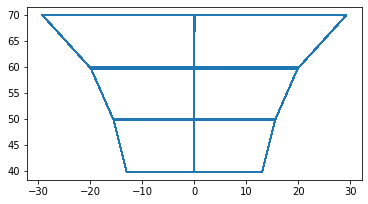

In [461]:
m.plot(facecolor="",edgecolor="C0")

In [480]:
viirs.downloadUrl.values

array(['https://earthexplorer.usgs.gov/download/external/options/VIIRS_VNP09H1/2247809211/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/VIIRS_VNP09H1/2247809222/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/VIIRS_VNP09H1/2247809252/INVSVC/',
       ...,
       'https://earthexplorer.usgs.gov/download/external/options/VIIRS_VNP09H1/2355820540/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/VIIRS_VNP09H1/2355820667/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/VIIRS_VNP09H1/2355821041/INVSVC/'],
      dtype=object)

# **VIIRS** daily 500m L2

In [466]:
prod = 'VIIRS_VNP09GA'
request_code = 'search'

In [467]:
def create_search_request(prod, aoi, t1, t2):
    
    return json.dumps({
        "datasetName": prod,
            "spatialFilter": {
                "filterType": "mbr",
                "lowerLeft": {
                    "latitude": aoi.bounds.miny.values[0],
                    "longitude": aoi.bounds.minx.values[0]
                },
                "upperRight": {
                    "latitude": aoi.bounds.maxy.values[0],
                    "longitude": aoi.bounds.maxx.values[0] 
                }
            },
            "temporalFilter": {
                "startDate": t1, #"2006-01-01",
                "endDate": t2, #"2007-12-01"
            },
        "maxResults": 49000,
        "startingNumber": 1,
        "sortOrder": "ASC",
        "apiKey": token
    })
    

In [468]:

res = []
for yr in tqdm(range(1990,2020)):
    t1 = f'{yr}-01-01'
    t2 = f'{yr}-12-31'
    try:
        r = requests.get(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/{request_code}?jsonRequest={create_search_request(prod, aoi, t1, t2)}')
        res.append(json.loads(r.text))
        print(yr, 'woop')
    except:
        print('boo')
#     res.append(json.loads(, verify=False).text)['data']['results'])
#     except Exception as e:
#         print(e)
#         break


  3%|▎         | 1/30 [00:08<04:10,  8.65s/it]

1990 woop


  7%|▋         | 2/30 [00:16<03:51,  8.27s/it]

1991 woop


 10%|█         | 3/30 [00:22<03:31,  7.82s/it]

1992 woop


 13%|█▎        | 4/30 [00:29<03:18,  7.62s/it]

1993 woop


 17%|█▋        | 5/30 [00:37<03:06,  7.46s/it]

1994 woop


 20%|██        | 6/30 [00:44<02:56,  7.35s/it]

1995 woop


 23%|██▎       | 7/30 [00:51<02:48,  7.34s/it]

1996 woop


 27%|██▋       | 8/30 [00:58<02:42,  7.37s/it]

1997 woop


 30%|███       | 9/30 [01:06<02:37,  7.52s/it]

1998 woop


 33%|███▎      | 10/30 [01:14<02:32,  7.64s/it]

1999 woop


 37%|███▋      | 11/30 [01:22<02:25,  7.67s/it]

2000 woop


 40%|████      | 12/30 [01:29<02:17,  7.62s/it]

2001 woop


 43%|████▎     | 13/30 [01:37<02:08,  7.57s/it]

2002 woop


 47%|████▋     | 14/30 [01:45<02:02,  7.67s/it]

2003 woop


 50%|█████     | 15/30 [01:52<01:54,  7.60s/it]

2004 woop


 53%|█████▎    | 16/30 [01:59<01:44,  7.45s/it]

2005 woop


 57%|█████▋    | 17/30 [02:07<01:36,  7.46s/it]

2006 woop


 60%|██████    | 18/30 [02:14<01:29,  7.43s/it]

2007 woop


 63%|██████▎   | 19/30 [02:21<01:21,  7.40s/it]

2008 woop


 67%|██████▋   | 20/30 [02:29<01:14,  7.44s/it]

2009 woop


 70%|███████   | 21/30 [02:40<01:16,  8.45s/it]

2010 woop


 73%|███████▎  | 22/30 [02:47<01:04,  8.10s/it]

2011 woop


 77%|███████▋  | 23/30 [03:18<01:43, 14.80s/it]

2012 woop


 80%|████████  | 24/30 [03:47<01:55, 19.18s/it]

2013 woop


 83%|████████▎ | 25/30 [04:18<01:53, 22.71s/it]

2014 woop


 87%|████████▋ | 26/30 [04:50<01:41, 25.47s/it]

2015 woop


 90%|█████████ | 27/30 [05:24<01:24, 28.05s/it]

2016 woop


 93%|█████████▎| 28/30 [05:59<01:00, 30.17s/it]

2017 woop


 97%|█████████▋| 29/30 [06:30<00:30, 30.42s/it]

2018 woop


100%|██████████| 30/30 [07:02<00:00, 14.10s/it]

2019 woop


collate responses into df, add geometry and save to csv

In [469]:
viirs2 = []
for i in res:
    viirs2.append(pd.DataFrame(i['data']['results']))
viirs2 = pd.concat(viirs2)
viirs2.shape

(17376, 18)

In [470]:
viirs2['geometry'] = [shape(i) for i in viirs2.spatialFootprint.values]
m = gpd.GeoDataFrame(viirs2, geometry='geometry', crs=('epsg:4326'))

In [471]:
m = gpd.GeoDataFrame(viirs2, geometry='geometry', crs=('epsg:4326'))

In [472]:
viirs2.to_csv("/tmp/data/outputs/SD_20200611_United Kingdom_VIIRS_VNP09GA.csv")

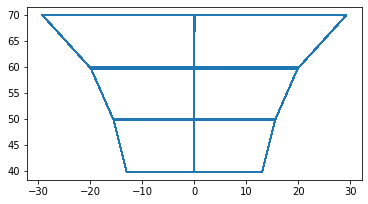

In [473]:
m.plot(facecolor="",edgecolor="C0")

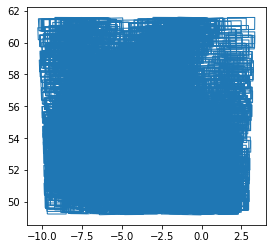

In [431]:
m.plot(facecolor="",edgecolor="C0")

In [479]:
m.shape

(17376, 20)

In [19]:
modcsv.downloadUrl.values[:2]

array(['https://earthexplorer.usgs.gov/download/external/options/MODIS_MCD43A4_V6/2217526348/INVSVC/',
       'https://earthexplorer.usgs.gov/download/external/options/MODIS_MCD43A4_V6/2217527011/INVSVC/'],
      dtype=object)

In [20]:
modcsv.dataAccessUrl.values[:2]

array(['https://earthexplorer.usgs.gov/order/process?dataset_name=MODIS_MCD43A4_V6&ordered=2217526348&node=INVSVC',
       'https://earthexplorer.usgs.gov/order/process?dataset_name=MODIS_MCD43A4_V6&ordered=2217527011&node=INVSVC'],
      dtype=object)

In [23]:
modcsv.summary.values[:2]

array(['Entity ID: MCD43A4.A2000055.h18v02.006.2016101151508.hdf, Coordinates: 65.15 , 12.4144, Acquisition Date: 16-FEB-00, Category: MODIS BRDF and Albedo',
       'Entity ID: MCD43A4.A2000055.h17v04.006.2016101153852.hdf, Coordinates: 45.061 , -7.1562, Acquisition Date: 16-FEB-00, Category: MODIS BRDF and Albedo'],
      dtype=object)

# **POST-CSVS** 

paths

In [15]:
csvs = {
    'vrs_h1'   : '/tmp/data/outputs/SD_20200611_United Kingdom_VIIRS_VNP09H1.csv',
    'vrs_ga'   : '/tmp/data/outputs/SD_20200611_United Kingdom_VIIRS_VNP09GA.csv',
    'mod_syn'  : '/tmp/data/outputs/SD_20200611_United Kingdom_MODIS_MCD43A4_V6.csv',
    's3_syn'   : '/tmp/data/outputs/SD_20200611_United Kingdom_S3_SY_2_SYN___.csv',
    'ast_l1t'  : '/tmp/data/outputs/SD_20200611_United Kingdom_ASTER_L1T.csv',
    'lsoli_l2' : '/tmp/data/outputs/SD_20200612_United Kingdom_LS_OLI.csv',
    'lsetm_l2' : '/tmp/data/outputs/SD_20200612_United Kingdom_LS_ETM.csv',
    'lstm_l2'  : '/tmp/data/outputs/SD_20200612_United Kingdom_LS_TM.csv',
    's1_grd'   : '/tmp/data/outputs/SD_20200612_United Kingdom_S1_GRD.csv',
    's2_l1c'   : '/tmp/data/outputs/SD_20200608_United Kingdom_S2_L1C.csv',
    's2_l2a'   : '/tmp/data/outputs/SD_20200608_United Kingdom_S2_L2A.csv'
}

open + df + gdf + get date

In [16]:
def loadcsv(csv_path):
    df = pd.read_csv(csv_path)
    
    # load geoms
    if 'geometry' in df.columns:
        df['geometry'] = df['geometry'].apply(wkt.loads)
    elif 'spatialFootprint' in df.columns:
        df['geometry'] = df['spatialFootprint'].apply(wkt.loads)
    # gen dates
    if 'Acquisition Date' in df.columns:
        df['date'] = [ i.date() for i in pd.to_datetime(df['Acquisition Date']) ]
    elif 'beginposition' in df.columns:
        df['date'] = [ i.date() for i in pd.to_datetime(df['beginposition']) ]
    elif 'acquisitionDate' in df.columns:
        df['date'] = [ i.date() for i in pd.to_datetime(df['acquisitionDate']) ]
    
    return gpd.GeoDataFrame(df, geometry='geometry', crs=('epsg:4326'))

gdfs = {}
for key in csvs.keys():
    gdfs[key] = loadcsv(csvs[key])

bounds for consistent extent

In [17]:
bds = [ gdfs[i].total_bounds for i in gdfs.keys() ]

In [18]:
xmin,xmax = min([i[0] for i in bds]), max([i[2] for i in bds])
ymin,ymax = min([i[1] for i in bds]), max([i[3] for i in bds])

make daily frame of animation

In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[['continent', 'geometry', 'pop_est']]

continents = world.dissolve(by='continent', aggfunc='sum')

In [20]:
pars = {
    'lsoli_l2' : {'face':'none',
                  'edge':'darkgreen',
                  'hatch':"",
                  'alpha':1,
                  'label':'LS_OLI-30m'},
    'lsetm_l2' : {'face':'none',
                  'edge':'limegreen',
                  'hatch':"",
                  'alpha':1,
                  'label':'LS_ETM-30m'},
    'lstm_l2'  : {'face':'none',
                  'edge':'greenyellow',
                  'hatch':"",
                  'alpha':1,
                  'label':'LS_TM-30m'},
    's2_l1c'   : {'face':'none',
                  'edge':'red',
                  'hatch':"",
                  'alpha':1,
                  'label':'S2_L1C-10m'},
    's2_l2a'   : {'face':'none',
                  'edge':'darkred',
                  'hatch':"",
                  'alpha':1,
                  'label':'S2_L2A-10m'},
    's1_grd'   : {'face':'none',
                  'edge':'royalblue',
                  'hatch':"",
                  'alpha':1,
                  'label':'S1_GRD-20m'},
    's3_syn'   : {'face':'none',
                  'edge':'lightcoral',
                  'hatch':"",
                  'alpha':1,
                  'label':'S2_SYN-300m'},
    'vrs_ga'   : {'face':'none',
                  'edge':'lightsteelblue',
                  'hatch':"\\",
                  'alpha':0.25,
                  'label':'VIIRS_GA-500m'},
    'vrs_h1'   : {'face':'slategrey',
                  'edge':'slategrey',
                  'hatch':"\\",
                  'alpha':0.1,
                  'label':'VIIRS_H1-1000m'},
    'ast_l1t'  : {'face':'none',
                  'edge':'darkorange',
                  'hatch':"",
                  'alpha':1,
                  'label':'AST_1T-30m'},
    'mod_syn'  : {'face':'none',
                  'edge':'gainsboro',
                  'hatch':"/",
                  'alpha':0.25,
                  'label':'MOD_L3-500m'}
}



time steps for gif

In [21]:
start = datetime.strptime("1990-01-01", "%Y-%m-%d")
end = datetime.strptime("2020-06-01", "%Y-%m-%d") # datetime.today()
dys = pd.date_range(start, end)
dys = np.unique([ i.date() for i in dys ])
dys

array([datetime.date(1990, 1, 1), datetime.date(1990, 1, 2),
       datetime.date(1990, 1, 3), ..., datetime.date(2020, 5, 30),
       datetime.date(2020, 5, 31), datetime.date(2020, 6, 1)],
      dtype=object)

In [ ]:
%%time
for dt in tqdm(dys[3437:]):
        
    fig, ax = plt.subplots(figsize=(10,10),dpi=200)
    leg_patches=[]
    
    continents.plot(ax=ax,facecolor="g",edgecolor="g",alpha=0.05)
    aoi.plot(ax=ax, facecolor="g",edgecolor="g",alpha=0.5)
    
    for key in gdfs:
        if 'nothing' not in key:
            df = gdfs[key]
    #         print(pars[key]['face'], pars[key]['edge'], pars[key]['label'], pars[key]['alpha'])
            df[(df.date==dt)].plot(ax=ax, facecolor=pars[key]['face'], edgecolor=pars[key]['edge'], label=pars[key]['label'], alpha=pars[key]['alpha'],hatch=pars[key]['hatch'])
            leg_patches.append(mpatches.Patch(facecolor=pars[key]['face'], edgecolor=pars[key]['edge'], label=pars[key]['label'], alpha=pars[key]['alpha'],hatch=pars[key]['hatch']))
        
    ax.set_title(f'{dt}');
    ax.set_xlabel("longitude");
    ax.set_ylabel("latitude");
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(which='both')
    ax.legend(handles=leg_patches, loc='left', shadow=True, ncol=1);
    fig.tight_layout()
#     fig.show()
    fig.savefig(f'/tmp/data/outputs/all_daily_acqs_{dt}.png')
    fig,ax=None,None

 45%|████▍     | 3438/7673 [48:17<5:36:06,  4.76s/it]

In [ ]:
print('t')

In [288]:
import xarray as xr

In [83]:
filename = '/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf'

# xr.open_dataset('/tmp/data/outputs/MCD43A4.A2020153.h17v03.006.2020162042803.hdf')

import rasterio
with rasterio.open(filename) as src:
    subdatasets = src.subdatasets

In [84]:
subdatasets

['HDF4_EOS:EOS_GRID:/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf:MOD_Grid_BRDF:BRDF_Albedo_Band_Mandatory_Quality_Band1',
 'HDF4_EOS:EOS_GRID:/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf:MOD_Grid_BRDF:Nadir_Reflectance_Band3',
 'HDF4_EOS:EOS_GRID:/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf:MOD_Grid_BRDF:Nadir_Reflectance_Band4',
 'HDF4_EOS:EOS_GRID:/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf:MOD_Grid_BRDF:Nadir_Reflectance_Band5',
 'HDF4_EOS:EOS_GRID:/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf:MOD_Grid_BRDF:Nadir_Reflectance_Band6',
 'HDF4_EOS:EOS_GRID:/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf:MOD_Grid_BRDF:Nadir_Reflectance_Band7',
 'HDF4_EOS:EOS_GRID:/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf:MOD_Grid_BRDF:BRDF_Albedo_Band_Mandatory_Quality_Band2',
 'HDF4_EOS:EOS_GRID:/tmp/data/outputs/MCD43A4.A2020008.h00v08.006.2020017034128.hdf:MOD_Grid_BRDF:

In [305]:
da = xr.open_rasterio(subdatasets[2])
da

<xarray.DataArray (band: 1, y: 2400, x: 2400)>
[5760000 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.671e+06 6.671e+06 6.671e+06 ... 5.56e+06 5.56e+06
  * x        (x) float64 -1.112e+06 -1.111e+06 -1.111e+06 ... -695.0 -231.7
Attributes:
    transform:     (463.3127165279167, 0.0, -1111950.519667, 0.0, -463.312716...
    crs:           +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=637100...
    res:           (463.3127165279167, 463.3127165279165)
    is_tiled:      0
    nodatavals:    (32767.0,)
    scales:        (0.0001,)
    offsets:       (0.0,)
    descriptions:  ('Nadir_Reflectance_Band4',)
    units:         ('reflectance, no units',)

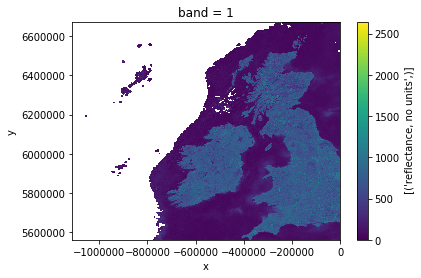

In [307]:
da.where(da!=32767).plot()